# Masking the Data
Placing a limit on the frequency may help you achieve an optimal result in the fitting process.

Even on a good dataset, we can get a sizable error if we take into consideration every single frequency of data. This is because there can be some data that is considered an outlier. Take for example, 'DE_40_1_30.mpt' which by all accounts, is a good dataset without any unusual spikes or drops in the data. Let's take a look at if we were to import all frequencies in the file.

In [63]:
#Locate the data, prepare for import of the MPT file
#Import necessary packaging
from utils.tools import *
path=r"C:\Users\cjang\Desktop\impedance_data\data\\"
data = ['DE_49_5_30.mpt']
ex_mpt = mpt_data(path,data)

No handles with labels found to put in legend.


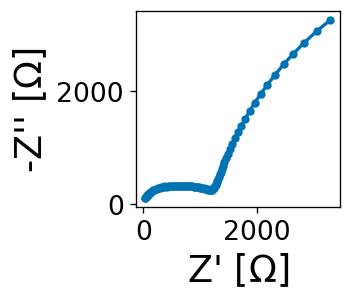

In [64]:
ex_mpt.mpt_plot()

If we take the guessing iterator and run it on this dataset, the guessing iterator has to find a fitting equation that satisfies every single point on this set, or something that is close.

Because the iterator cut out at 1000 iterations and return the set of coefficients at that state, we cannot say with full confidence that this is the best fit because it didn't necessarily satisfy the threshold. If we graph this 'optimal' set of coefficients, we aren't guaranteed a great fitting graph...

What we can do is eliminate some of the frequencies from the file to make it easier to get a more accurate graph. But how do we determine which frequencies to drop from the file? 

# Linear Kramer Kronig Analysis

The Linear Kramer Kronig Analysis determines the causality, linearity, and stability of the dataset. It'll help you determine a mask by examining the residual graph. Running the function ex_mpt.LinKK() will allow you to see where your residuals are fluctuating the most. From here you can determine on your own what your boundaries should be.

cycle || No. RC-elements ||   u
[1]            5            0.8


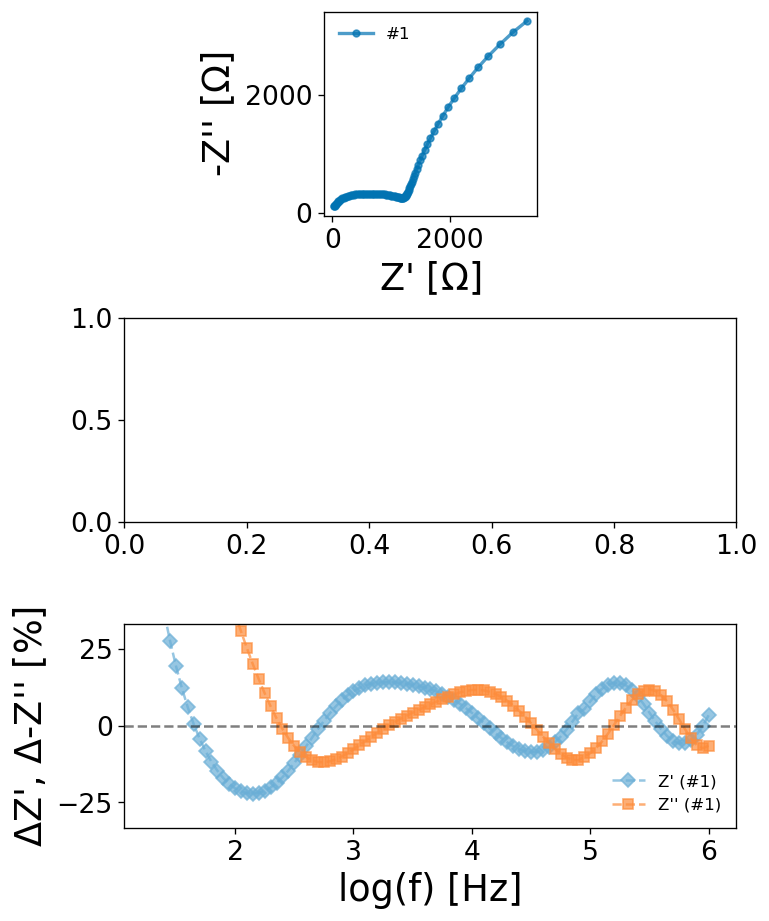

In [65]:
#Will be updated
ex_mpt.Lin_KK(plot = 'w_data')

In [75]:
#Notice how the graph shows log(f) not f. We must translate back
#so instead of 1.75 and 6, we must insert 10**1.75 and 10**6
masked_mpt = mpt_data(path,data, mask = [10**4.5, 10**2.5])
#masked_mpt.guesser(Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2)

No handles with labels found to put in legend.


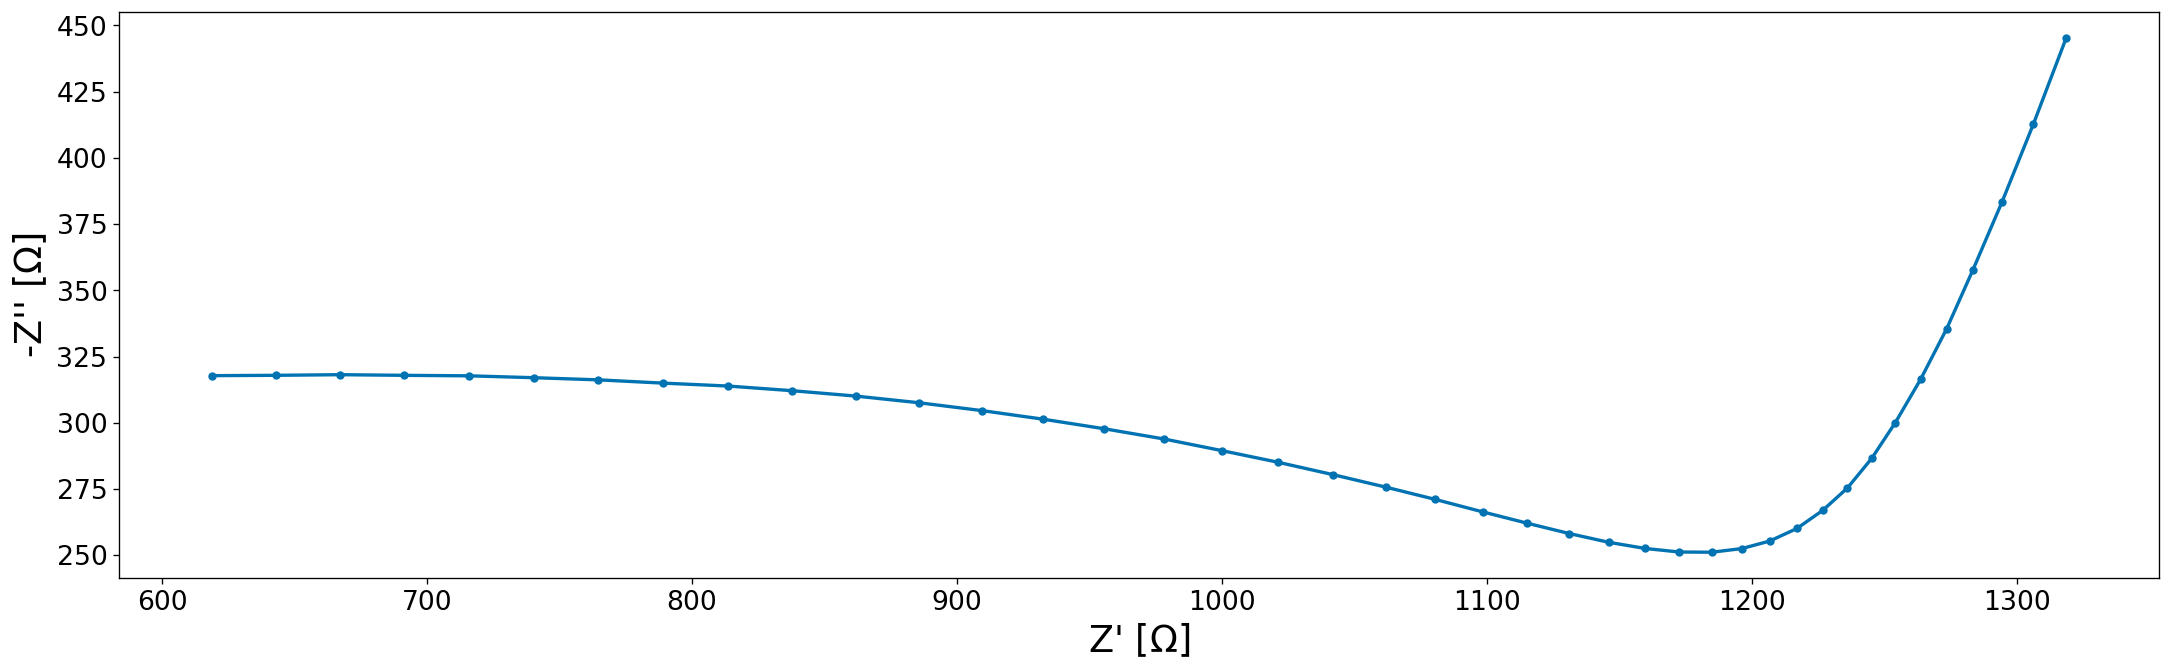

In [76]:
masked_mpt.set_new_gph_dims(20,30)
masked_mpt.mpt_plot()

# Automated Masker

The process above is ideal if all your fitting is a single mpt file. If we want to fit multiple files, or hundreds of files in a batch folder, we need a more automated process. We can call on ex_mpt.masker() to find the best window for us. 

Calling masker takes the average of the distance between the residuals and uses it as an additional threshold, so if the residual lands outside the threshold, all frequencies associated with that residual point will be omitted from the graph. We then run the guessing iterator and see if it achieves 1e-10 error within a thousand iterations. If it does not, we shrink the threshold by a factor of 0.9 to increase exclusivity. 


In [77]:
def leastsq_errorfunc(params, w, re, im, circuit, weight_func):
    if circuit == 'R-RQ-RQ':
        re_fit = cir_RsRQRQ_fit(params, w).real
        im_fit = -cir_RsRQRQ_fit(params, w).imag
    else:
        print('Circuit is not defined in leastsq_errorfunc()')
    
    error = [(re-re_fit)**2, (im-im_fit)**2] #sum of squares
    print('ERROR: ', sum(error))
    #Different Weighing options, see Lasia
    if weight_func == 'modulus':
        weight = [1/((re_fit**2 + im_fit**2)**(1/2)), 1/((re_fit**2 + im_fit**2)**(1/2))]
    elif weight_func == 'proportional':
        weight = [1/(re_fit**2), 1/(im_fit**2)]
    elif weight_func == 'unity':
        unity_1s = []
        for k in range(len(re)):
            unity_1s.append(1) #makes an array of [1]'s, so that the weighing is == 1 * sum of squres.
        weight = [unity_1s, unity_1s]
    else:
        print('weight not defined in leastsq_errorfunc()')
        
    S = np.array(weight) * error #weighted sum of squares
    print('Weighted SUM OF SQUARES: ',sum(S)) 
    return sum(S)

In [78]:
def guesser(ex_mpt, Rs_guess = 1, R_guess = 1, n_guess = 0.8, fs_guess = 1, R2_guess = 1, n2_guess = 0.8, fs2_guess = 0.2):
        
    params = Parameters()
    guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
    #adding to the parameters package to send to the fitting function
    params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=10**6)
    params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=10**6)
    params.add('n', value=guess_package[2], min=.65, max=1)
    params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
    params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=10**6)
    params.add('n2', value=guess_package[5], min=.65, max=1)
    params.add('fs2', value=guess_package[6], min=10**-2, max=10**6)
    ex_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')

    counter = 0

    while ex_mpt.low_error >= 100 and counter <= 1000:
        counter += 1
        print('ITERATION NO. : ', counter)
        Rs_guess = ex_mpt.fit_Rs[0]

        R_guess = ex_mpt.fit_R[0]
        n_guess = ex_mpt.fit_n[0]
        fs_guess = ex_mpt.fit_fs[0]

        R2_guess = ex_mpt.fit_R2[0]
        n2_guess = ex_mpt.fit_n2[0]
        fs2_guess = ex_mpt.fit_fs2[0]

        guess_package = [Rs_guess, R_guess, n_guess, fs_guess, R2_guess, n2_guess, fs2_guess]
        #adding to the parameters package to send to the fitting function
        params = Parameters()
        params.add('Rs', value=guess_package[0], min=guess_package[0]*.01, max=guess_package[0]*100)
        params.add('R', value=guess_package[1], min=guess_package[1]*.1, max=guess_package[1]*10)
        params.add('n', value=guess_package[2], min=.65, max=1)
        params.add('fs', value=guess_package[3], min=10**0.5, max=10**6)
        params.add('R2', value=guess_package[4], min=guess_package[4]*.1, max=guess_package[4]*10)
        params.add('n2', value=guess_package[5], min=.65, max=1)
        params.add('fs2', value=guess_package[6], min=10**-2, max=10**1)
        ex_mpt.mpt_fit(params, circuit = 'R-RQ-RQ')

    ex_mpt.mpt_plot(fitting = 'on')

49237186.93190135
49237186.93190135
49237186.93190135
49237184.96418596
49237186.923389256
49237186.93190248
49237186.931901336
49237186.930979095
49237186.93190151
49237186.930202276
30784437561403.31
30784437563809.12
30784437828200.418
30784437573659.668
30784436952500.348
30784427331578.02
30784428579990.984
30784443090901.023
52841013353.006935
52841014795.28749
52841023032.91923
52841013010.423676
52841028374.74523
52841047718.70732
52841013038.272446
52841013720.19366
14196685228049.975
14279062481916.572
239594570730.0345
72168773393.31828
47209882182.076004
47209883546.28311
47209891175.656296
47209881409.310326
47209876852.10831
47209866948.98881
47209882114.46639
47209882260.9169
44386091989.37755
44386093312.43999
44386100681.50019
44386091920.00055
44386092016.85228
44386099563.060036
44386091971.91545
44386092010.32953
39235203796.44907
39235205040.33901
39235211791.77548
39235203528.736885
39235204075.24288
39235192735.33332
39235203756.6173
39235203843.58024
34303419377

2082032.1017216444
2082032.0565811244
2082030.6164854628
2082032.0566004831
2082032.0566017043
2082032.0560261777
2081911.0935968573
2081910.939970983
2081911.1386967625
2081911.093577667
2081909.6531837862
2081911.0935968456
2081911.0935981267
2081911.0941965245
2081798.151996387
2081797.998625937
2081798.197077946
2081798.151977376
2081796.711158541
2081798.151996375
2081798.1519977187
2081798.1513705524
2081692.582769214
2081692.4296446329
2081692.6278349725
2081692.58275038
2081691.1414075568
2081692.5827692014
2081692.5827706093
2081692.5834204631
2081593.8052696465
2081593.6523813275
2081593.8503218375
2081593.8052509897
2081592.3632891066
2081593.8052696334
2081593.8052711082
2081593.8045920653
2081501.2902452587
2081501.1375836306
2081501.3352858494
2081501.2902267785
2081499.847560619
2081501.2902452452
2081501.2902467889
2081501.2909482466
2081420.1306120688
2081419.9781442513
2081420.175642995
2081420.1305937439
2081418.6872715533
2081420.1306120583
2081420.1306132753
208142

2079547.3056982113
2079545.7174960817
2079547.305704931
2079547.3057061336
2079547.3051334228
2079540.4321670826
2079540.284181719
2079540.477551207
2079540.4321604115
2079538.8426124025
2079540.432167074
2079540.432168111
2079540.4326607166
2079534.7253548868
2079534.577375222
2079534.770744257
2079534.7253482784
2079533.1343330753
2079534.725354878
2079534.7253559488
2079534.7248442683
2079529.0655354538
2079528.9175615308
2079529.110930107
2079529.0655289066
2079527.4730389474
2079529.0655354445
2079529.0655365507
2079529.0660630327
2079523.4534718476
2079523.3055037018
2079523.4988718207
2079523.4534653618
2079521.8594931446
2079523.4534718376
2079523.4534729824
2079523.452926205
2079517.8860087013
2079517.7380463567
2079517.93141403
2079517.886002276
2079516.2905547565
2079517.8860086908
2079517.8860098757
2079517.8865723268
2079512.364393071
2079512.216436561
2079512.4098037903
2079512.3643867073
2079510.7674565106
2079512.3643930606
2079512.3643942883
2079512.3638102575
2079505.

2078890.008483498
2078891.749456897
2078891.749458038
2078891.7489080494
2078885.088857124
2078884.9414645447
2078885.134823249
2078885.0888545916
2078883.3463769555
2078885.0888571145
2078885.0888582843
2078885.0894187365
2078877.0358841408
2078876.8884970802
2078877.081855413
2078877.0358816287
2078875.2920721446
2078877.0358841326
2078877.0358850989
2078877.0354224304
2078870.1384593004
2078869.991078205
2078870.1844366512
2078870.138456811
2078868.3931549997
2078870.1384592922
2078870.138460278
2078870.1389314497
2078863.2612568305
2078863.113881759
2078863.3072402908
2078863.261254365
2078861.5144531776
2078863.2612568222
2078863.2612578287
2078863.2607735565
2078856.400313596
2078856.252944607
2078856.4463031949
2078856.4003111538
2078854.6520036615
2078856.4003135874
2078856.4003146156
2078856.400807739
2078849.5561617394
2078849.408798882
2078849.6021575045
2078849.5561593196
2078847.8063528019
2078849.5561617306
2078849.5561627813
2078849.5556559921
2078842.7247537188
2078842.

2078484.9312991071
2078484.784251031
2078484.9776091964
2078484.9312975847
2078483.1072144744
2078484.931299099
2078484.9313000767
2078484.9308286342
2078477.3369340745
2078477.1898925335
2078477.3832507145
2078477.3369325665
2078475.5113544033
2078477.336934066
2078477.3369350522
2078477.3374088153
2078469.7401728607
2078469.5931378775
2078469.7864960665
2078469.7401713664
2078467.9130918977
2078469.740172852
2078469.7401738472
2078469.739693345
2078462.1383473745
2078461.9913189732
2078462.1846771627
2078462.1383458944
2078460.3097729397
2078462.138347366
2078462.1383483696
2078462.1388312315
2078454.5321434336
2078454.3851216394
2078454.5784798204
2078454.5321419674
2078452.702069362
2078454.5321434252
2078454.5321444378
2078454.531654711
2078446.9191083135
2078446.7720931452
2078446.965451312
2078446.9191068606
2078445.0875354933
2078446.9191083051
2078446.9191093266
2078446.9196014516
2078439.3005778426
2078439.1535693149
2078439.3469274675
2078439.3005764035
2078437.467514176
207

2077590.758900848
2077581.6358886021
2077581.4895985052
2077581.682955273
2077581.6358880415
2077579.651229765
2077581.6358885951
2077581.6358894652
2077581.6354745782
2077572.4975746572
2077572.3512921073
2077572.5446488587
2077572.497574102
2077570.511437617
2077572.4975746502
2077572.49757552
2077572.4979885337
2077563.3451964497
2077563.1989214628
2077563.3922781916
2077563.3451959
2077561.357568778
2077563.3451964427
2077563.3451973125
2077563.3447823576
2077554.1775731253
2077554.0313057085
2077554.2246624185
2077554.17757258
2077552.1884629847
2077554.1775731186
2077554.1775739884
2077554.1779870903
2077544.9959579352
2077544.849698095
2077545.0430547886
2077544.9959573946
2077543.0053734875
2077544.995957928
2077544.9959587983
2077544.9955437335
2077535.7983169234
2077535.6520646717
2077535.845421347
2077535.7983163884
2077533.8062457792
2077535.7983169165
2077535.7983177865
2077535.7987310188
2077526.5869563606
2077526.440711711
2077526.6340683645
2077526.5869558307
2077524.59

2077066.6433598532
2077056.6846108655
2077056.5387508795
2077056.7321066011
2077056.684610528
2077054.6187004247
2077056.684610858
2077056.6846117533
2077056.6850413922
2077046.7104762043
2077046.5646243272
2077046.7579800251
2077046.7104758697
2077044.643093843
2077046.7104761973
2077046.710477093
2077046.7100449007
2077036.7198979636
2077036.574054203
2077036.7674098795
2077036.7198976325
2077034.6510450977
2077036.7198979561
2077036.7198988532
2077036.7203296712
2077026.7145328042
2077026.5686971704
2077026.762052825
2077026.7145324755
2077024.644210836
2077026.714532797
2077026.714533695
2077026.7141002982
2077016.6925862168
2077016.5467587167
2077016.7401143534
2077016.6925858925
2077014.620796571
2077016.6925862096
2077016.6925871088
2077016.6930191463
2077006.6557050915
2077006.5098857381
2077006.7032413543
2077006.6557047686
2077004.5824424005
2077006.6557050843
2077006.655705984
2077006.6552713423
2076996.6024257843
2076996.4566145919
2076996.6499701825
2076996.6024254654
2076

2075849.1241890856
2075848.9793077388
2075849.1726612123
2075849.1241889661
2075846.8953470094
2075849.1241890688
2075849.1241909624
2075849.1250413049
2075834.8183751493
2075834.6735024368
2075834.86685521
2075834.8183750305
2075832.5882486932
2075834.8183751358
2075834.8183766832
2075834.8176435274
2075823.4251348737
2075823.2802713607
2075823.4736244713
2075823.4251347561
2075821.193545444
2075823.42513486
2075823.4251364986
2075823.4258997238
2075812.1960622799
2075812.0512081913
2075812.2445615341
2075812.1960621632
2075809.9630059341
2075812.1960622645
2075812.1960640026
2075812.195261689
2075801.12533443
2075800.9804899648
2075801.1738434515
2075801.125334314
2075798.8908076405
2075801.1253344137
2075801.1253362584
2075801.1261707523
2075790.2156364082
2075790.0708017468
2075790.264155304
2075790.2156362934
2075787.9796358934
2075790.215636391
2075790.2156383498
2075790.2147615845
2075775.1154333851
2075774.9706072807
2075775.1639599283
2075775.1154332708
2075772.8781820745
2075

2074460.0457259463
2074459.9019149337
2074460.095261871
2074460.045725902
2074457.666387672
2074460.045725931
2074460.0457276828
2074460.046539634
2074446.9718378384
2074446.828037855
2074447.021384722
2074446.9718377942
2074444.5910979453
2074446.9718378226
2074446.9718396624
2074446.9709930636
2074430.4171336626
2074430.273343364
2074430.466689297
2074430.417133619
2074428.035202475
2074430.4171336507
2074430.4171350857
2074430.417830491
2074416.787180828
2074416.6434009634
2074416.8367471348
2074416.7871807846
2074414.4038703574
2074416.7871808154
2074416.7871823243
2074416.7864546706
2074403.290283043
2074403.146513822
2074403.3398601338
2074403.2902830006
2074400.905596137
2074403.29028303
2074403.2902846176
2074403.291038435
2074389.9230446958
2074389.7792863077
2074389.9726326715
2074389.9230446536
2074387.5369654815
2074389.9230446818
2074389.923046354
2074389.9222578898
2074376.678870058
2074376.5351226644
2074376.7284690149
2074376.6788700167
2074374.2914022529
2074376.678870

2072848.8209678158
2072849.014300454
2072848.9635679913
2072846.442613257
2072848.963567994
2072848.9635696225
2072848.9643466028
2072833.372502671
2072833.2299147241
2072833.42324716
2072833.3725026543
2072830.8502659637
2072833.3725026571
2072833.37250433
2072833.371707181
2072817.801136122
2072817.6585604688
2072817.8518926918
2072817.8011361063
2072815.2776057078
2072817.8011361076
2072817.8011378262
2072817.8019474235
2072799.5258928337
2072799.3833280439
2072799.5766593353
2072799.525892818
2072797.0012589432
2072799.5258928228
2072799.5258941657
2072799.5252247413
2072783.4351203633
2072783.2925672154
2072783.485898624
2072783.4351203488
2072780.9092217009
2072783.4351203518
2072783.4351217286
2072783.4358020471
2072767.4029899947
2072767.2604486442
2072767.453780091
2072767.4029899787
2072764.87583115
2072767.4029899833
2072767.4029913947
2072767.402293545
2072751.417292899
2072751.274763478
2072751.468094898
2072751.4172928836
2072748.8888604974
2072751.4172928869
2072751.4172

2070996.162898086
2070996.3562068779
2070996.304138924
2070993.6527387882
2070996.3041389207
2070996.3041401913
2070996.304783144
2070977.9379265173
2070977.79669895
2070977.9900074939
2070977.937926511
2070975.2853819313
2070977.937926507
2070977.9379277793
2070977.9372809953
2070959.5602878043
2070959.4190735533
2070959.6123818338
2070959.560287798
2070956.9065883728
2070959.5602877939
2070959.5602890681
2070959.560933786
2070941.172440012
2070941.0312391196
2070941.2245471193
2070941.1724400066
2070938.5175992034
2070941.1724400017
2070941.172441278
2070941.1717927067
2070922.7692956878
2070922.6281081783
2070922.8214158916
2070922.7692956817
2070920.113303329
2070922.7692956773
2070922.7692969556
2070922.7699434627
2070904.3527979467
2070904.2116238475
2070904.404931268
2070904.3527979406
2070901.695661728
2070904.3527979366
2070904.3527992165
2070904.3521488328
2070885.9186781538
2070885.7775174957
2070885.9708246107
2070885.9186781482
2070883.260393993
2070885.9186781435
2070885.

2068905.7078950068
2068884.8959863938
2068884.756269836
2068884.9495411466
2068884.8959863922
2068882.1267899133
2068884.8959863852
2068884.8959875037
2068884.8965679414
2068864.0621904223
2068863.9224888294
2068864.1157596793
2068864.06219042
2068861.2919615651
2068864.0621904135
2068864.062191531
2068864.061608922
2068843.2047853405
2068843.065098728
2068843.2583691156
2068843.2047853388
2068840.4335377528
2068843.2047853316
2068843.2047864485
2068843.2053661088
2068822.3252157725
2068822.185544154
2068822.3788140821
2068822.32521577
2068819.5529402797
2068822.3252157636
2068822.3252168798
2068822.3246350326
2068801.4215585124
2068801.2819019035
2068801.4751713711
2068801.4215585103
2068798.648257365
2068801.4215585035
2068801.4215596186
2068801.4221385408
2068780.4960069999
2068780.356365421
2068780.5496344205
2068780.496006998
2068777.721682426
2068780.496006991
2068780.496008105
2068780.4954269812
2068759.5460391317
2068759.4064125894
2068759.5996811304
2068759.5460391298
2068756.

2066493.2544369479
2066490.3813414802
2066493.2544369402
2066493.2544380522
2066493.2550206142
2066469.7244379716
2066469.5864448245
2066469.779659237
2066469.7244379711
2066466.8504496485
2066469.7244379637
2066469.724439076
2066469.723853608
2066446.1670512275
2066446.0290747974
2066446.2222885946
2066446.1670512266
2066443.2921724468
2066446.167051219
2066446.1670523314
2066446.167635596
2066422.5844304706
2066422.4464707745
2066422.6396839558
2066422.58443047
2066419.708663606
2066422.5844304617
2066422.5844315756
2066422.5838453933
2066398.9742168237
2066398.836273878
2066399.0294864425
2066398.974216823
2066396.0975533903
2066398.9742168146
2066398.9742179294
2066398.9748019136
2066375.3394028326
2066375.2014766582
2066375.3946885997
2066375.339402832
2066372.461850619
2066375.3394028242
2066375.3394039392
2066375.3388170246
2066351.6770582607
2066351.5391488753
2066351.7323601916
2066351.6770582604
2066348.7986196727
2066351.677058252
2066351.6770593675
2066351.6776440893
206632

2063726.5107303266
2063700.6779315108
2063700.5419117273
2063700.7350431231
2063700.6779315106
2063697.712369474
2063700.6779314922
2063700.6779337549
2063700.6789535116
2063674.6813004932
2063674.545300319
2063674.738430532
2063674.6813004927
2063671.714954095
2063674.6813004743
2063674.6813027358
2063674.6802777294
2063648.5431827155
2063648.407201927
2063648.600331086
2063648.543182715
2063645.57606097
2063648.543182697
2063648.5431849563
2063648.5442041236
2063622.2879992183
2063622.1520376466
2063622.345165851
2063622.2879992179
2063619.320109832
2063622.2879991995
2063622.2880014575
2063622.286977005
2063595.9278066342
2063595.7918641448
2063595.9849914743
2063595.927806634
2063592.959156378
2063595.9278066156
2063595.927808873
2063595.9288275335
2063569.480066419
2063569.344142916
2063569.5372694246
2063569.4800664184
2063566.5106560178
2063569.4800664005
2063569.4800686562
2063569.47904468
2063542.951652052
2063542.8157474594
2063543.0088731935
2063542.9516520519
2063539.981497

2060656.3845438731
2060656.3254037146
2060653.286827242
2060656.3254036969
2060656.325405927
2060656.3264310206
2060626.4470914428
2060626.3132269718
2060626.5062512907
2060626.4470914428
2060623.4079187652
2060626.4470914244
2060626.447093655
2060626.4460628878
2060596.53533744
2060596.4014938711
2060596.594516996
2060596.53533744
2060593.4955662289
2060596.5353374218
2060596.535339652
2060596.5363650809
2060566.5945554196
2060566.4607327774
2060566.6537547002
2060566.5945554196
2060563.554183278
2060566.5945554017
2060566.5945576318
2060566.5935265296
2060536.6207901272
2060536.4869884346
2060536.6800091506
2060536.6207901272
2060533.5798244965
2060536.6207901093
2060536.6207923396
2060536.6218181013
2060506.617825133
2060506.4840444115
2060506.6770639168
2060506.617825133
2060503.576263628
2060506.617825115
2060506.617827346
2060506.6167959105
2060476.5816277238
2060476.447867991
2060476.640886284
2060476.5816277238
2060473.5394729022
2060476.5816277056
2060476.581629936
2060476.582

2058966.1416046056
2058966.0088993968
2058966.2018539973
2058966.1416046056
2058963.0720835011
2058966.141604588
2058966.1416068182
2058966.1405681723
2058934.5147244188
2058934.3820412715
2058934.574994479
2058934.5147244188
2058931.4446790684
2058934.5147244008
2058934.514726631
2058934.5157598637
2058902.8576565643
2058902.7249955006
2058902.9179473128
2058902.8576565643
2058899.787084722
2058902.8576565469
2058902.8576587774
2058902.8566199145
2058871.1661492996
2058871.0335103385
2058871.2264607528
2058871.1661492996
2058868.095058289
2058871.1661492821
2058871.166151512
2058871.1671849578
2058839.4441929774
2058839.3115761399
2058839.5045251544
2058839.4441929774
2058836.3725805655
2058839.4441929595
2058839.4441951897
2058839.4431561178
2058807.68769255
2058807.5550978607
2058807.7480454675
2058807.68769255
2058804.6155660595
2058807.6876925323
2058807.6876947621
2058807.6887284147
2058775.9004206127
2058775.7678480935
2058775.9607942912
2058775.9004206127
2058772.827773081
2058

2055358.3341356183
2055358.271546944
2055355.15339865
2055358.2715469273
2055358.2715491038
2055358.2705122652
2055323.0038632888
2055322.8736952706
2055323.0664746552
2055323.0038632888
2055319.8853458508
2055323.0038632723
2055323.0038654474
2055323.0048967097
2055287.7028512075
2055287.572707748
2055287.7654852855
2055287.7028512075
2055284.5839537324
2055287.702851191
2055287.7028533653
2055287.7018168669
2055252.3651465892
2055252.2350277107
2055252.427803397
2055252.3651465892
2055249.2458761088
2055252.3651465725
2055252.3651487455
2055252.3661796662
2055216.9945306056
2055216.8644363296
2055217.0572101653
2055216.9945306056
2055213.8748896306
2055216.9945305886
2055216.9945327614
2055216.9934966166
2055181.5865941427
2055181.4565245006
2055181.6492964728
2055181.5865941427
2055178.4665852597
2055181.5865941262
2055181.5865962973
2055181.5876268626
2055146.1455671592
2055146.015522169
2055146.2082922785
2055146.1455671592
2055143.025192885
2055146.1455671426
2055146.1455693133
2

2053325.6357259122
2053328.7727915663
2053328.772793675
2053328.771771194
2053291.5084129618
2053291.3796576979
2053291.5723263877
2053291.5084129618
2053288.37104549
2053291.508412946
2053291.5084150531
2053291.5094319421
2053254.2099603224
2053254.081230993
2053254.2738975647
2053254.2099603224
2053251.0722935428
2053254.2099603065
2053254.2099624125
2053254.2089406345
2053216.8731906177
2053216.7444872486
2053216.9371516965
2053216.8731906177
2053213.7352270884
2053216.8731906018
2053216.873192706
2053216.8742088922
2053179.50216626
2053179.3734888758
2053179.5661511957
2053179.50216626
2053176.3639084802
2053179.5021662442
2053179.5021683471
2053179.5011472867
2053142.0924940307
2053141.963842659
2053142.1565028422
2053142.0924940307
2053138.95394457
2053142.0924940147
2053142.0924961162
2053142.0935115851
2053104.6483896426
2053104.5197643023
2053104.712422351
2053104.6483896426
2053101.5095466839
2053104.6483896265
2053104.6483917267
2053104.6473713988
2053067.1658713287
2053067.

2049089.8252672695
2049048.507868217
2049048.3820637953
2049048.5744722323
2049048.507868217
2049045.346003251
2049048.5078682033
2049048.5078700995
2049048.5088286903
2049007.1528118234
2049007.0270361817
2049007.2194418928
2049007.1528118234
2049003.990788496
2049007.15281181
2049007.1528137033
2049007.1518511558
2048965.7571526333
2048965.631405799
2048965.8238087764
2048965.7571526333
2048962.594973441
2048965.757152619
2048965.7571545104
2048965.7581116154
2048924.3247623877
2048924.199044386
2048924.3914446277
2048924.3247623877
2048921.1624338124
2048924.3247623742
2048924.324764263
2048924.3238032234
2048882.851228322
2048882.7255391844
2048882.9179366794
2048882.851228322
2048879.688748838
2048882.8512283084
2048882.8512301943
2048882.8521857953
2048841.3408256446
2048841.2151653958
2048841.4075601415
2048841.3408256446
2048838.1781976912
2048841.3408256306
2048841.3408275147
2048841.3398679993
2048799.7894110177
2048799.6637796853
2048799.8561716748
2048799.7894110177
2048796

2046756.087765379
2046759.256209983
2046759.256211736
2046759.2571245949
2046715.7764629845
2046715.652282885
2046715.8445319703
2046715.7764629845
2046712.6079327003
2046715.776462972
2046715.7764647221
2046715.775548497
2046672.2547119437
2046672.1305621697
2046672.3228081744
2046672.2547119437
2046669.086094545
2046672.2547119313
2046672.2547136785
2046672.2556246156
2046628.6950906815
2046628.570971262
2046628.7632141823
2046628.6950906815
2046625.526388559
2046628.6950906692
2046628.6950924136
2046628.694178134
2046585.0936098946
2046584.96952086
2046585.1617606848
2046585.0936098946
2046581.924825502
2046585.0936098823
2046585.0936116236
2046585.0945206233
2046541.4539610369
2046541.3299024133
2046541.5221391388
2046541.4539610369
2046538.2850928726
2046541.4539610248
2046541.4539627635
2046541.4530504446
2046497.7724971694
2046497.6484689878
2046497.8407026047
2046497.7724971694
2046494.6035515803
2046497.772497157
2046497.7724988926
2046497.7734059384
2046454.0526263607
2046453

2044307.9994286362
2044304.8280157875
2044307.9994286255
2044307.9994302103
2044307.9985724462
2044262.292147277
2044262.1696783667
2044262.3617477524
2044262.292147277
2044259.1207154947
2044262.2921472662
2044262.2921488476
2044262.2930015272
2044216.5455968173
2044216.423159844
2044216.6152257652
2044216.5455968173
2044213.3741446768
2044216.5455968066
2044216.5455983852
2044216.5447430287
2044170.7563215771
2044170.6339165734
2044170.8259790193
2044170.7563215771
2044167.5848514717
2044170.7563215662
2044170.7563231413
2044170.7571734218
2044124.9278152448
2044124.80544224
2044124.9975012061
2044124.9278152448
2044121.7563257506
2044124.9278152343
2044124.927816806
2044124.9269638753
2044079.0566844519
2044078.9343434789
2044079.1263989538
2044079.0566844519
2044075.8851817164
2044079.056684441
2044079.0566860097
2044079.057533873
2044033.1460403497
2044033.0237314356
2044033.2157834154
2044033.1460403497
2044029.9745229627
2044033.146040339
2044033.1460419043
2044033.145191416
204

2039104.263477027
2039104.261588827
2039075.238399411
2039075.1196384304
2039075.311293209
2039075.238399411
2039072.070211987
2039075.2383993575
2039075.2384057352
2039075.2405242082
2039050.9663364044
2039050.8476283425
2039051.0392783333
2039050.9663364044
2039047.7975047103
2039050.966336337
2039050.9663440753
2039050.9639446118
2038928.6063649873
2038928.487669384
2038928.6792931878
2038928.6063649873
2038925.4389841047
2038928.6063649838
2038928.6063655359
2038928.6060907864
2038875.6068115318
2038875.48814034
2038875.67976433
2038875.6068115318
2038872.439803003
2038875.6068115286
2038875.6068120592
2038875.6070610995
2038778.821968943
2038778.7033515102
2038778.8949753803
2038778.821968943
2038775.6554897714
2038778.821968935
2038778.821970151
2038778.8212622567
2038878.6756478027
2038878.5571566583
2038878.7488345949
2038878.6756478027
2038875.5057892792
2038878.6756476199
2038878.6756654624
2038878.6795308674
2038582.2626346266
2038582.1441742089
2038582.335773557
2038582.262

2032942.324198066
2032939.174415251
2032942.3241980302
2032942.3242028141
2032942.322357783
2032894.361544774
2032894.247163326
2032894.4382638289
2032894.361544774
2032891.2118145071
2032894.361544733
2032894.3615501006
2032894.3635152832
2032819.9309633058
2032819.8166180872
2032820.0077069404
2032819.9309633058
2032816.7817363758
2032819.9309632792
2032819.9309670185
2032819.9293810944
2032767.3631366708
2032767.2488301008
2032767.4399163062
2032767.3631366708
2032764.2141312642
2032767.3631366398
2032767.363140869
2032767.3648416419
2032717.0862142853
2032716.9719490206
2032717.163031728
2032717.0862142853
2032713.9373421795
2032717.0862142497
2032717.086219016
2032717.0843758206
2032668.9209617907
2032668.8067400507
2032668.9978186374
2032668.9209617907
2032665.77214203
2032668.9209617502
2032668.9209671004
2032668.9229306423
2032594.3793925224
2032594.2652071482
2032594.4562740542
2032594.3793925224
2032591.2310828473
2032594.3793924954
2032594.3793962237
2032594.3778113206
20325

2026856.3459741923
2026856.3441039363
2026783.2575715655
2026783.147524855
2026783.337992196
2026783.2575715655
2026780.136562858
2026783.257571542
2026783.257575099
2026783.2591485076
2026723.769707499
2026723.6597031993
2026723.8501656929
2026723.769707499
2026720.6490375947
2026723.769707473
2026723.769711287
2026723.7680578786
2026665.3094162822
2026665.199456006
2026665.3899130612
2026665.3094162822
2026662.1890345016
2026665.3094162547
2026665.3094203346
2026665.3111335388
2026607.7119405204
2026607.6020255387
2026607.7924767258
2026607.7119405204
2026604.5918107233
2026607.7119404906
2026607.7119448457
2026607.710149469
2026550.8259849818
2026550.716116295
2026550.9065613048
2026550.8259849818
2026547.7060781096
2026550.8259849497
2026550.8259895872
2026550.8278431508
2026477.685221263
2026477.575393226
2026477.7658273098
2026477.685221263
2026474.5658145787
2026477.6852212397
2026477.685224785
2026477.6836428083
2026417.8921687058
2026417.7823832682
2026417.9728124097
2026417.8

2019987.4648327855
2019987.654524247
2019987.5699851988
2019984.4873296495
2019987.569985174
2019987.5699891006
2019987.5682565535
2019925.0392528665
2019924.9341504525
2019925.1238344964
2019925.0392528665
2019921.9569177525
2019925.0392528404
2019925.0392570181
2019925.0410457645
2019863.1168819969
2019863.0118304065
2019863.2015068093
2019863.1168819969
2019860.0348409656
2019863.1168819687
2019863.1168864034
2019863.115018629
2019783.412271469
2019783.3072635466
2019783.4969270364
2019783.412271469
2019780.3308283456
2019783.412271449
2019783.412274657
2019783.4137954973
2019717.8454743726
2019717.740512616
2019717.9301699304
2019717.8454743726
2019714.7644721933
2019717.8454743512
2019717.8454777766
2019717.8438839414
2019653.2923292106
2019653.1874152666
2019653.3770658104
2019653.2923292106
2019650.2117186792
2019653.2923291877
2019653.2923328385
2019653.293981365
2019589.579655671
2019589.4747908334
2019589.6644341704
2019589.579655671
2019586.4994044572
2019589.5796556466
2019

2012648.5263622561
2012648.4374026817
2012645.4005092555
2012648.4374026586
2012648.4374065886
2012648.4391773506
2012579.9529944856
2012579.8532496246
2012580.0419991487
2012579.9529944856
2012576.916482508
2012579.9529944614
2012579.95299853
2012579.9511782443
2012496.52760214
2012496.4279045141
2012496.6166400723
2012496.52760214
2012493.4917323382
2012496.5276021233
2012496.527605069
2012496.5290876594
2012424.8241606015
2012424.72451285
2012424.9132404842
2012424.8241606015
2012421.788811158
2012424.824160584
2012424.8241636595
2012424.8226318269
2012353.850902338
2012353.7513058376
2012353.9400250246
2012353.850902338
2012350.8160398104
2012353.8509023197
2012353.8509055267
2012353.8524694252
2012283.452994821
2012283.3534506278
2012283.5421609862
2012283.452994821
2012280.4185908358
2012283.4529948016
2012283.4529981415
2012283.451384792
2012213.49661183
2012213.3971207582
2012213.585822008
2012213.49661183
2012210.462644071
2012213.4966118096
2012213.496615283
2012213.498259165

2004680.391124939
2004677.4064978617
2004680.391124923
2004680.3911279973
2004680.3926911962
2004604.8745684444
2004604.7806946454
2004604.968325829
2004604.8745684444
2004601.8904284085
2004604.874568428
2004604.8745715485
2004604.8729846582
2004529.3903539903
2004529.2965377062
2004529.4841576153
2004529.3903539903
2004526.4066984714
2004529.3903539735
2004529.3903571395
2004529.3919498352
2004453.9214071298
2004453.8276484942
2004454.0152570861
2004453.9214071298
2004450.9382322486
2004453.9214071126
2004453.9214103224
2004453.9197945404
2004378.4425380582
2004378.3488371677
2004378.5364344202
2004378.4425380582
2004375.4598408248
2004378.4425380402
2004378.4425412938
2004378.44416173
2004302.9456781691
2004302.852035096
2004303.039620994
2004302.9456781691
2004299.963458445
2004302.9456781514
2004302.945681446
2004302.9440385508
2004227.412291769
2004227.3187065693
2004227.5062810997
2004227.412291769
2004224.430552294
2004227.4122917508
2004227.412295086
2004227.413941492
2004151.

1996271.2595689585
1996271.2595717462
1996271.2580560471
1996190.2517442063
1996190.1641778683
1996190.3505071588
1996190.2517442063
1996187.3230713373
1996190.2517441926
1996190.251746975
1996190.2532534075
1996109.1984761376
1996109.1109709209
1996109.2972870932
1996109.1984761376
1996106.2703355837
1996109.1984761236
1996109.1984789006
1996109.19696617
1996028.0937864578
1996028.0063423975
1996028.1926454331
1996028.0937864578
1996025.1661793634
1996028.093786444
1996028.093789215
1996028.095292555
1995946.9441465293
1995946.8567636618
1995947.043053545
1995946.9441465293
1995944.0170739554
1995946.9441465156
1995946.9441492807
1995946.9426398277
1995865.7433837608
1995865.656062122
1995865.842338831
1995865.7433837608
1995862.8168447253
1995865.743383747
1995865.7433865063
1995865.7448864554
1995784.4982514188
1995784.4109910466
1995784.5972545638
1995784.4982514188
1995781.5722469618
1995784.498251405
1995784.498254158
1995784.4967482742
1995703.2025096393
1995703.1153105681
19957

1987278.5248119286
1987278.420790607
1987275.5500216505
1987278.4207905969
1987278.420792785
1987278.4194659349
1987192.9649401475
1987192.8842119789
1987193.069011854
1987192.9649401475
1987190.0947185394
1987192.9649401375
1987192.9649423228
1987192.966262361
1987107.4709331733
1987107.390270623
1987107.5750552837
1987107.4709331733
1987104.601255806
1987107.4709331633
1987107.4709353466
1987107.4696099279
1987021.9335529944
1987021.8529561027
1987022.0377255299
1987021.9335529944
1987019.0644207061
1987021.9335529846
1987021.9335551653
1987021.9348737847
1986936.35844997
1986936.277918778
1986936.4626729528
1986936.35844997
1986933.4898635312
1986936.3584499601
1986936.3584521383
1986936.3571281533
1986850.7397455794
1986850.6592801276
1986850.8440190302
1986850.7397455794
1986847.8717038934
1986850.7397455694
1986850.7397477455
1986850.7410649436
1986765.0833806735
1986765.0029810062
1986765.187704614
1986765.0833806735
1986762.2158845055
1986765.0833806635
1986765.083382837
198676

1977909.8800130845
1977909.8800150196
1977909.881257105
1977820.245484529
1977820.172008652
1977820.3550615776
1977820.245484529
1977817.4338401083
1977820.2454845207
1977820.2454864534
1977820.244239745
1977730.570829092
1977730.497423172
1977730.6804585918
1977730.570829092
1977727.759731334
1977730.5708290837
1977730.5708310143
1977730.5720715737
1977640.8617114103
1977640.7883754838
1977640.9713933817
1977640.8617114103
1977638.051162697
1977640.861711402
1977640.8617133303
1977640.8604681615
1977551.1126614276
1977551.0393955372
1977551.222395887
1977551.1126614276
1977548.3026588513
1977551.112661419
1977551.1126633452
1977551.1139023767
1977461.3292340161
1977461.2560382
1977461.4390209818
1977461.3292340161
1977458.519779954
1977461.3292340077
1977461.3292359316
1977461.3279923042
1977371.5059118124
1977371.43278611
1977371.6157513007
1977371.5059118124
1977368.6970069243
1977371.5059118038
1977371.5059137254
1977371.5071512265
1977281.6479692552
1977281.574913709
1977281.75786

1972925.465542921
1972925.4655447316
1972925.4643403161
1972833.8303128565
1972833.7607430653
1972833.9427995007
1972833.8303128565
1972831.0487503665
1972833.830312849
1972833.8303146567
1972833.8315132435
1972742.1624414525
1972742.0929437757
1972742.2749814447
1972742.1624414525
1972739.381424897
1972742.162441445
1972742.1624432507
1972742.1612404303
1972650.4567584102
1972650.3873328855
1972650.5693517614
1972650.4567584102
1972647.6762866569
1972650.4567584028
1972650.456760206
1972650.4579572098
1972558.718391249
1972558.6490379134
1972558.831037974
1972558.718391249
1972555.9384648188
1972558.7183912415
1972558.718393043
1972558.7171918196
1972466.942328483
1972466.8730473777
1972467.0550285976
1972466.942328483
1972464.162947951
1972466.9423284756
1972466.9423302747
1972466.9435256917
1972375.1335754734
1972375.064366637
1972375.2463289953
1972375.1335754734
1972372.3547396527
1972375.133575466
1972375.1335772632
1972375.1323776399
1972283.2872019587
1972283.2180654276
1972283

1962832.6014694325
1962737.3706122348
1962737.3090491805
1962737.488937827
1962737.3706122348
1962734.6474811572
1962737.3706122288
1962737.3706138025
1962737.3717236784
1962642.1098424147
1962642.0483555067
1962642.2282227124
1962642.1098424147
1962639.3872468506
1962642.1098424084
1962642.1098439803
1962642.1087306063
1962546.8154793277
1962546.7540686019
1962546.933914337
1962546.8154793277
1962544.0934197188
1962546.8154793214
1962546.815480891
1962546.816589061
1962451.4923031544
1962451.4309686488
1962451.6107928867
1962451.4923031544
1962448.7707783203
1962451.4923031484
1962451.492304716
1962451.4911930605
1962356.1357083577
1962356.0744501073
1962356.2542528217
1962356.1357083577
1962353.4147171632
1962356.1357083514
1962356.1357099167
1962356.1368163791
1962260.750536103
1962260.6893541438
1962260.8691353092
1962260.750536103
1962258.0300805012
1962260.7505360967
1962260.7505376602
1962260.749427728
1962165.3319140219
1962165.2708083866
1962165.4505679796
1962165.3319140219
1

1951837.7269497644
1951837.602171362
1951834.9359300327
1951837.6021713363
1951837.6021774188
1951837.5994650759
1951736.5131702127
1951736.4606916546
1951736.6380047107
1951736.5131702127
1951733.8474703257
1951736.5131701878
1951736.5131762489
1951736.5158651383
1951635.4063414487
1951635.3539441961
1951635.5312320506
1951635.4063414487
1951632.7411831291
1951635.4063414233
1951635.4063474631
1951635.4036432991
1951534.2701999042
1951534.2178839883
1951534.395146598
1951534.2701999042
1951531.6055833914
1951534.270199879
1951534.270205898
1951534.272886712
1951433.1162903835
1951433.0640558377
1951433.2412931744
1951433.1162903835
1951430.4522158066
1951433.1162903586
1951433.1162963565
1951433.1136004245
1951331.933218294
1951331.881065151
1951332.0582771772
1951331.933218294
1951329.269684452
1951331.9332182691
1951331.9332242457
1951331.9358969287
1951230.7329545855
1951230.6808828781
1951230.8580695656
1951230.7329545855
1951228.0699601588
1951230.732954561
1951230.7329605161
195

1946256.5233738343
1946256.3955027931
1946253.7585393044
1946256.395502773
1946256.3955080488
1946256.3980561867
1946154.635960034
1946154.5880067188
1946154.763887599
1946154.635960034
1946151.999515365
1946154.6359600145
1946154.635965285
1946154.6334004125
1946052.846570525
1946052.798700544
1946052.9745546123
1946052.846570525
1946050.2106463837
1946052.846570505
1946052.8465757698
1946052.8491233229
1945951.0380711488
1945950.9902845281
1945951.1661117575
1945951.0380711488
1945948.402666377
1945951.0380711292
1945951.0380763886
1945951.035512126
1945849.1995400584
1945849.1518368248
1945849.327637187
1945849.1995400584
1945846.5646536008
1945849.1995400388
1945849.1995452926
1945849.2020922618
1945747.3420048507
1945747.2943850325
1945747.4701585008
1945747.3420048507
1945744.7076383072
1945747.3420048316
1945747.3420100803
1945747.3394464275
1945645.4543731872
1945645.4068368108
1945645.5825833592
1945645.4543731872
1945642.8205255049
1945645.4543731674
1945645.4543784105
194564

1940623.3073387078
1940623.2639257687
1940623.4383155755
1940623.3073387078
1940620.6986898445
1940623.3073386906
1940623.3073436762
1940623.3047952335
1940520.2146821483
1940520.1713540766
1940520.3457153903
1940520.2146821483
1940517.60654317
1940520.214682131
1940520.2146871113
1940520.2172188929
1940417.1042299585
1940417.0609867836
1940417.235319566
1940417.1042299585
1940414.496599721
1940417.1042299415
1940417.1042349164
1940417.101687082
1940313.9650461215
1940313.9218878725
1940314.0961920985
1940313.9650461215
1940311.3579262383
1940313.9650461043
1940313.9650510743
1940313.9675822712
1940210.8079415897
1940210.7648682941
1940210.9391439236
1940210.8079415897
1940208.201329597
1940210.8079415727
1940210.8079465379
1940210.805399311
1940107.622321164
1940107.5793328504
1940107.7535798554
1940107.622321164
1940105.0162186676
1940107.6223211468
1940107.6223261065
1940107.6248567197
1940004.41882153
1940004.3759182259
1940004.5501365692
1940004.41882153
1940001.8132287175
1940004

1929572.8636490796
1929573.0348253727
1929572.8979159344
1929570.3422832026
1929572.8979159214
1929572.8979203983
1929572.8954040923
1929467.5327444973
1929467.498565282
1929467.669709326
1929467.5327444973
1929464.9776028306
1929467.532744484
1929467.5327489572
1929467.5352497913
1929362.1531601562
1929362.119068603
1929362.2901803616
1929362.1531601562
1929359.5985096944
1929362.1531601434
1929362.1531646117
1929362.1506489099
1929256.7486882177
1929256.7146843506
1929256.8857637893
1929256.7486882177
1929254.194526739
1929256.7486882047
1929256.7486926685
1929256.7511929194
1929151.3302163328
1929151.2963001744
1929151.4673472566
1929151.3302163328
1929148.7765451963
1929151.3302163198
1929151.3302207794
1929151.3277056818
1929045.8868614442
1929045.853033019
1929046.0240477046
1929045.8868614442
1929043.333679657
1929045.8868614314
1929045.8868658862
1929045.8893655532
1928940.4294411794
1928940.39570051
1928940.56668276
1928940.4294411794
1928937.8767488769
1928940.4294411666
1928

1918301.9807672787
1918301.9782829655
1918194.7229759903
1918194.69820992
1918194.865714878
1918194.7229759903
1918192.2188337867
1918194.7229759805
1918194.7229800054
1918194.7254499109
1918087.4544150042
1918087.4297388003
1918087.5972072603
1918087.4544150042
1918084.9507438627
1918087.4544149947
1918087.4544190157
1918087.4519353048
1917980.164416988
1917980.1398306678
1917980.3072625797
1917980.164416988
1917977.6612193757
1917980.1644169774
1917980.1644209947
1917980.1668903157
1917872.8633804594
1917872.8388840416
1917873.0062793735
1917872.8633804594
1917870.3606542186
1917872.8633804491
1917872.863384463
1917872.8609013536
1917765.5408241781
1917765.5164176798
1917765.683776388
1917765.5408241781
1917763.0385695046
1917765.5408241677
1917765.5408281775
1917765.5432969148
1917658.2076926222
1917658.1833760617
1917658.350698099
1917658.2076926222
1917655.7059096212
1917658.207692612
1917658.207696617
1917658.2052141114
1917550.8530933415
1917550.8288667356
1917550.996152063
1917

1912379.5953776212
1912377.116504278
1912379.5953776124
1912379.5953814297
1912379.5978355736
1912271.4918247554
1912271.4720265153
1912271.637460065
1912271.4918247554
1912269.0134148553
1912271.4918247461
1912271.4918285604
1912271.4893611108
1912163.3684245409
1912163.3487170713
1912163.5141117298
1912163.3684245409
1912160.890478268
1912163.3684245318
1912163.368428342
1912163.3708819011
1912055.235491997
1912055.2158753136
1912055.3812310363
1912055.235491997
1912052.7580094538
1912055.2354919885
1912055.2354957948
1912055.2330289476
1911947.0825642105
1911947.063038327
1911947.228355068
1911947.0825642105
1911944.6055444912
1911947.082564202
1911947.0825680043
1911947.0850209794
1911838.9203209924
1911838.9008859245
1911839.0661636381
1911838.9203209924
1911836.443764196
1911838.9203209835
1911838.9203247826
1911838.9178585373
1911730.738276653
1911730.7189324144
1911730.8841710547
1911730.738276653
1911728.2621829615
1911730.7382766441
1911730.7382804395
1911730.7407328296
19116

1900621.449858222
1900623.879451815
1900623.8794552537
1900623.881877794
1900514.3192387992
1900514.309318176
1900514.4702808922
1900514.3192387992
1900511.890094062
1900514.3192387922
1900514.3192422278
1900514.3168073047
1900404.7415697107
1900404.7317411362
1900404.8926597936
1900404.7415697107
1900402.3128740115
1900404.7415697041
1900404.7415731365
1900404.7439950898
1900295.1567863442
1900295.147049827
1900295.3079243754
1900295.1567863442
1900292.7285397765
1900295.1567863375
1900295.1567897664
1900295.1543554473
1900185.554469338
1900185.5448248864
1900185.705655279
1900185.554469338
1900183.1266720782
1900185.5544693314
1900185.554472757
1900185.556894123
1900075.9449595658
1900075.9354071887
1900076.0961933692
1900075.9449595658
1900073.5176106973
1900075.944959559
1900075.9449629812
1900075.942529265
1899966.3179232534
1899966.3084629592
1899966.4692048759
1899966.3179232534
1899963.8910229527
1899966.317923247
1899966.3179266658
1899966.3203474446
1899856.6840589526
1899856

1888834.028365898
1888834.028369004
1888834.0259661584
1888723.235107065
1888723.235073259
1888723.3910201937
1888723.235107065
1888720.8534253885
1888723.2351070594
1888723.235110162
1888723.2375008538
1888612.4362561253
1888612.4363149656
1888612.5922120188
1888612.4362561253
1888610.0550125109
1888612.4362561202
1888612.4362592201
1888612.433856982
1888501.6215105755
1888501.6216620635
1888501.7775091878
1888501.6215105755
1888499.2407051977
1888501.6215105702
1888501.6215136673
1888501.623903765
1888390.8013051772
1888390.8015493162
1888390.9573464436
1888390.8013051772
1888388.4209390797
1888390.801305172
1888390.8013082664
1888390.798906637
1888279.9650776999
1888279.9654144912
1888280.1211615703
1888279.9650776999
1888277.585150117
1888279.9650776947
1888279.9650807858
1888279.9674702906
1888169.1233838385
1888169.123813284
1888169.279510258
1888169.1233838385
1888166.7438939277
1888169.1233838333
1888169.1233869214
1888169.120985899
1888058.2659293436
1888058.266451446
1888058.

1876920.6435106862
1876920.793833327
1876920.6337219574
1876918.2981332827
1876920.6337219535
1876920.6337247626
1876920.6360837356
1876808.7525585871
1876808.7624398908
1876808.912706083
1876808.7525585871
1876806.4174019576
1876808.7525585827
1876808.7525613892
1876808.7501916182
1876696.8564343662
1876696.8664082414
1876697.0166179144
1876696.8564343662
1876694.5217090829
1876696.856434362
1876696.8564371658
1876696.8587955346
1876584.9556305308
1876584.965696974
1876585.1158500656
1876584.9556305308
1876582.6213375842
1876584.9556305266
1876584.955633328
1876584.9532641752
1876473.0397885651
1876473.0499475717
1876473.2000440115
1876473.0397885651
1876470.7059263785
1876473.0397885612
1876473.0397913593
1876473.0421491235
1876361.1194714187
1876361.1297229854
1876361.2797627114
1876361.1194714187
1876358.7860409787
1876361.1194714147
1876361.1194742108
1876361.1171056763
1876249.1840995492
1876249.1944436715
1876249.3444266128
1876249.1840995492
1876246.8511010394
1876249.184099545

1864781.1866796773
1864781.3305043024
1864781.1669263146
1864778.8777708707
1864781.1669263113
1864781.1669288527
1864781.1692547568
1864668.24261549
1864668.2624606916
1864668.4062211832
1864668.24261549
1864665.9538888384
1864668.242615487
1864668.242618026
1864668.240282025
1864555.3037980811
1864555.3237351102
1864555.4674313925
1864555.3037980811
1864553.0155004095
1864555.3037980776
1864555.3038006146
1864555.3061258974
1864442.3602404727
1864442.380269321
1864442.5239013173
1864442.3602404727
1864440.072371088
1864442.3602404692
1864442.3602430036
1864442.357907636
1864329.402186175
1864329.422306831
1864329.565874466
1864329.402186175
1864327.114746085
1864329.402186172
1864329.402188704
1864329.4045133647
1864216.4394430865
1864216.4596555412
1864216.603158732
1864216.4394430865
1864214.1524315982
1864216.4394430832
1864216.439445613
1864216.4371108797
1864103.4621871249
1864103.4824913666
1864103.6259300364
1864103.4621871249
1864101.1756036065
1864103.4621871214
1864103.4621

1852754.9046701808
1852757.148382097
1852757.1483844025
1852757.1506767937
1852643.1939887207
1852643.2235019295
1852643.360010134
1852643.1939887207
1852640.9507053567
1852643.1939887183
1852643.1939910213
1852643.191689169
1852529.2248291704
1852529.2544328535
1852529.3908681395
1852529.2248291704
1852526.9819753238
1852529.2248291678
1852529.2248314687
1852529.2271232149
1852415.250747917
1852415.2804420593
1852415.416804346
1852415.250747917
1852413.0083229593
1852415.2507479144
1852415.2507502136
1852415.2484490185
1852301.2616581984
1852301.2914427838
1852301.4277319713
1852301.2616581984
1852299.019662328
1852301.2616581959
1852301.2616604925
1852301.2639515938
1852187.2677383937
1852187.2976134066
1852187.4338294202
1852187.2677383937
1852185.0261725138
1852187.2677383912
1852187.267740686
1852187.2654401478
1852073.2587662416
1852073.2887316656
1852073.424874399
1852073.2587662416
1852071.0176297866
1852073.2587662388
1852073.258768531
1852073.2610589867
1851959.24486903
18519

1840391.437628176
1840391.5658080608
1840391.3985325727
1840389.2013397762
1840391.3985325708
1840391.3985346588
1840391.4007914814
1840276.34021985
1840276.379403978
1840276.5075007523
1840276.34021985
1840274.1434600677
1840276.340219848
1840276.3402219347
1840276.3379562572
1840161.2666314146
1840161.3059040455
1840161.433917611
1840161.2666314146
1840159.0703048485
1840161.2666314126
1840161.266633497
1840161.2688896449
1840046.1871742331
1840046.226535347
1840046.354465604
1840046.1871742331
1840043.9912803147
1840046.187174231
1840046.1871763137
1840046.1849113212
1839931.0923994628
1839931.1318490382
1839931.25969588
1839931.0923994628
1839928.896937678
1839931.0923994612
1839931.0924015418
1839931.0946570146
1839815.9918412305
1839816.031379247
1839816.159142561
1839815.9918412305
1839813.7968124426
1839815.9918412282
1839815.9918433072
1839815.9895790014
1839700.8759470272
1839700.915573464
1839701.0432531561
1839700.8759470272
1839698.6813514386
1839700.8759470251
1839700.875

1827902.465711075
1827902.5142379624
1827902.63281532
1827902.465711075
1827900.3155394855
1827902.4657110737
1827902.4657129662
1827902.4679324522
1827786.2295242823
1827786.2781371917
1827786.3966193914
1827786.2295242823
1827784.0797908644
1827786.2295242802
1827786.2295261712
1827786.227298396
1827669.9772734204
1827670.0259723258
1827670.1443592433
1827669.9772734204
1827667.8279783765
1827669.9772734188
1827669.9772753078
1827669.9794940846
1827553.718701087
1827553.7674859636
1827553.8857774837
1827553.718701087
1827551.5698438955
1827553.718701085
1827553.7187029722
1827553.7164759175
1827437.444187129
1827437.4930579509
1827437.6112539482
1827437.444187129
1827435.2957693306
1827437.444187127
1827437.4441890125
1827437.4464070788
1827321.163045098
1827321.2120018397
1827321.3301021988
1827321.163045098
1827319.0150655075
1827321.1630450964
1827321.16304698
1827321.1608206453
1827204.8660462298
1827204.9150888664
1827205.0330934613
1827204.8660462298
1827202.7185050466
1827204.

1815635.6770760957
1815518.2494537123
1815518.3069499396
1815518.4147270124
1815518.2494537123
1815516.1460888311
1815518.2494537116
1815518.2494554287
1815518.2516363312
1815400.8132108585
1815400.8707902024
1815400.978458123
1815400.8132108585
1815398.710290703
1815400.813210857
1815400.8132125733
1815400.811023907
1815283.3609807044
1815283.418643134
1815283.52620175
1815283.3609807044
1815281.2585054634
1815283.3609807033
1815283.3609824176
1815283.3631625737
1815165.9020491168
1815165.9597946038
1815166.067243773
1815165.9020491168
1815163.8000189343
1815165.9020491152
1815165.9020508279
1815165.8998629192
1815048.4272225024
1815048.4850510163
1815048.5923905936
1815048.4272225024
1815046.325637567
1815048.427222501
1815048.427224212
1815048.4294036205
1814930.9458475711
1814931.0037590843
1814931.1109889266
1814930.9458475711
1814928.8447080234
1814930.9458475697
1814930.9458492796
1814930.9436621277
1814813.4484603
1814813.506454782
1814813.613574729
1814813.4484603
1814811.3477

1809160.592280316
1809160.5922819509
1809160.5944424495
1809042.5576005154
1809042.6196238082
1809042.7211761884
1809042.5576005154
1809040.4787943806
1809042.5576005145
1809042.557602147
1809042.555434141
1808924.5075685568
1808924.5696733098
1808924.671108217
1808924.5075685568
1808922.4292104298
1808924.507568556
1808924.5075701876
1808924.5097299218
1808806.4513153706
1808806.5135015526
1808806.614818821
1808806.4513153706
1808804.373405991
1808806.4513153695
1808806.4513169997
1808806.449149768
1808688.3797293848
1808688.4419969642
1808688.5431964346
1808688.3797293848
1808686.3022683212
1808688.3797293836
1808688.3797310123
1808688.381889981
1808570.3019004285
1808570.364249374
1808570.4653308885
1808570.3019004285
1808568.2248872053
1808570.301900427
1808570.301902055
1808570.2997355969
1808452.208868793
1808452.2712990758
1808452.372262472
1808452.208868793
1808450.1323041897
1808452.2088687916
1808452.2088704174
1808452.2110286197
1808334.1096829325
1808334.1721945193
1808334.

1796354.35225216
1796354.3543705845
1796235.2835878688
1796235.3542249752
1796235.4421076002
1796235.2835878688
1796233.2534674853
1796235.2835878676
1796235.2835893473
1796235.2814638992
1796116.202584384
1796116.273299469
1796116.3610455906
1796116.202584384
1796114.1729165416
1796116.2025843833
1796116.202585861
1796116.2047034947
1795997.1184722781
1795997.1892653094
1795997.2768747369
1795997.1184722781
1795995.0892576333
1795997.1184722767
1795997.1184737538
1795997.1163491055
1795878.0222418064
1795878.0931127504
1795878.1805852822
1795878.0222418064
1795875.9934799212
1795878.0222418052
1795878.0222432811
1795878.0243601233
1795758.922969525
1795758.9939183507
1795759.0812537924
1795758.922969525
1795756.8946610538
1795758.9229695238
1795758.9229709979
1795758.9208471486
1795639.8117809393
1795639.8828076113
1795639.9700057718
1795639.8117809393
1795637.7839254413
1795639.8117809382
1795639.811782411
1795639.8138984633
1795520.697444298
1795520.7685487822
1795520.8556094621
179

1783463.0869755463
1783463.1590554665
1783463.0081860938
1783461.0265627988
1783463.008186093
1783463.0081874356
1783463.0102631876
1783343.5061500245
1783343.585013827
1783343.6569337244
1783343.5061500245
1783341.5249788065
1783343.506150024
1783343.506151365
1783343.5040690189
1783224.0010530243
1783224.079991145
1783224.1517507762
1783224.0010530243
1783222.020333915
1783224.0010530234
1783224.0010543636
1783224.0031293358
1783104.5014992622
1783104.580511666
1783104.6521107743
1783104.5014992622
1783102.521232258
1783104.5014992617
1783104.5015006007
1783104.4994190428
1782984.9992224653
1782985.0783091162
1782985.1497474518
1782984.9992224653
1782983.0194075934
1782984.9992224644
1782984.9992238022
1782985.0012979947
1782865.502848985
1782865.5820098503
1782865.653287182
1782865.502848985
1782863.5234862384
1782865.5028489842
1782865.5028503207
1782865.5007695488
1782746.003902068
1782746.083137113
1782746.154253172
1782746.003902068
1782744.0249909416
1782746.0039020672
1782746.

1776895.8902742309
1776895.9731023991
1776896.0359966897
1776895.8902742309
1776893.9334187466
1776895.8902742302
1776895.8902755082
1776895.888214011
1776776.6760357132
1776776.7589363635
1776776.8216560583
1776776.6760357132
1776774.7196278023
1776776.6760357122
1776776.6760369893
1776776.6780913325
1776657.4763167663
1776657.5592898645
1776657.6218346828
1776657.4763167663
1776655.5203563403
1776657.4763167654
1776657.4763180418
1776657.4742572953
1776538.2828661515
1776538.3659116651
1776538.4282813128
1776538.2828661515
1776536.3273536703
1776538.282866151
1776538.2828674256
1776538.284921025
1776419.1043471706
1776419.1874650647
1776419.2496592712
1776419.1043471706
1776417.149281511
1776419.1043471699
1776419.104348444
1776419.1022884452
1776299.9324722195
1776300.0156624631
1776300.077680923
1776299.9324722195
1776297.9778538367
1776299.9324722188
1776299.9324734916
1776299.9345263508
1776180.7761057173
1776180.8593682747
1776180.921210708
1776180.7761057173
1776178.821934514
1

1764252.1505938713
1764135.7153062124
1764135.8057745113
1764135.8480004726
1764135.7153062124
1764133.8056808978
1764135.7153062113
1764135.7153073782
1764135.7132818974
1764019.3258938189
1764019.416431179
1764019.458446819
1764019.3258938189
1764017.4166904096
1764019.3258938184
1764019.3258949844
1764019.3279137602
1763902.9891925468
1763903.079798938
1763903.1216038922
1763902.9891925468
1763901.0804106293
1763902.9891925463
1763902.989193711
1763902.9871687694
1763786.6974497219
1763786.7881251178
1763786.8297189847
1763786.6974497219
1763784.789088423
1763786.6974497212
1763786.6974508853
1763786.6994691335
1763670.45964819
1763670.5503925597
1763670.5917749545
1763670.45964819
1763668.5517075702
1763670.4596481891
1763670.4596493528
1763670.4576249404
1763554.2679375757
1763554.3587508907
1763554.3999214245
1763554.2679375757
1763552.3604172373
1763554.2679375752
1763554.2679387378
1763554.2699564644
1763438.1312358817
1763438.222118117
1763438.2630763967
1763438.1312358817
176

1752106.4227751296
1752106.4400311082
1752106.3250532656
1752104.457194486
1752106.325053265
1752106.3250543498
1752106.3270591078
1751999.8411140316
1751999.9389027362
1751999.9558988172
1751999.8411140316
1751997.9736004071
1751999.8411140307
1751999.8411151157
1751999.8391040575
1751893.5101199038
1751893.607975442
1751893.624711058
1751893.5101199038
1751891.6429501884
1751893.5101199034
1751893.5101209874
1751893.5121258767
1751787.3419844892
1751787.439906849
1751787.4563814611
1751787.3419844892
1751785.4751573955
1751787.3419844885
1751787.3419855721
1751787.3399743745
1751681.3302850279
1751681.4282742045
1751681.4444872309
1751681.3302850279
1751679.4637992831
1751681.3302850272
1751681.3302861098
1751681.3322911505
1751575.4850196452
1751575.5830756268
1751575.5990265168
1751575.4850196452
1751573.6188739354
1751575.4850196445
1751575.485020727
1751575.483009369
1751469.7996683249
1751469.8977911074
1751469.9134792993
1751469.7996683249
1751467.9338618051
1751469.7996683244


1742217.0890809547
1742218.9301127736
1742218.9301138343
1742218.9280545015
1742143.145737361
1742143.2505859253
1742143.2367521436
1742143.145737361
1742141.304830195
1742143.1457373605
1742143.1457384212
1742143.1477923924
1742067.8618898392
1742067.966807252
1742067.9526414564
1742067.8618898392
1742066.021103932
1742067.8618898385
1742067.8618908997
1742067.8598294589
1741993.0757746932
1741993.1807610139
1741993.1662623868
1741993.0757746932
1741991.2351057664
1741993.0757746927
1741993.075775754
1741993.0778318548
1741918.801509244
1741918.9065645365
1741918.8917322555
1741918.801509244
1741916.9609542526
1741918.8015092432
1741918.801510305
1741918.7994466927
1741845.0361614283
1741845.1412857533
1741845.126119023
1741845.0361614283
1741843.1957168817
1741845.0361614283
1741845.03616249
1741845.0382207823
1741771.7937170628
1741771.898910488
1741771.8834084566
1741771.7937170628
1741769.9533793991
1741771.7937170623
1741771.7937181247
1741771.791652279
1741699.0717072291
1741699

1738293.381394707
1738293.3837813078
1738309.872301496
1738309.9848006237
1738309.932227173
1738309.872301496
1738308.017005938
1738309.8723014952
1738309.8723027774
1738309.8698960992
1738327.7860852128
1738327.8986668284
1738327.8456727304
1738327.7860852128
1738325.9302821823
1738327.7860852121
1738327.786086504
1738327.7884968058
1738347.1439221976
1738347.2565865035
1738347.203171019
1738347.1439221976
1738345.287602332
1738347.1439221972
1738347.1439234992
1738347.1414922262
1738367.9474529026
1738368.0602001084
1738368.006362487
1738367.9474529026
1738366.0906068024
1738367.947452902
1738367.9474542148
1738367.9498896885
1738390.2179238428
1738390.3307541576
1738390.2764936748
1738390.2179238428
1738388.3605420103
1738390.2179238424
1738390.2179251662
1738390.215467805
1738413.9566159619
1738414.0695295911
1738414.0148455207
1738413.9566159619
1738412.0986892865
1738413.9566159614
1738413.9566172964
1738413.9590794323
1738439.1845851063
1738439.2975822573
1738439.242473896
17384

1749044.5235538953
1749046.4870245454
1749046.4870261375
1749046.4899390324
1748990.488706448
1748990.6106896978
1748990.5123773701
1748990.488706448
1748988.5249226207
1748990.488706448
1748990.4887065112
1748990.4886422914
1749155.8146040505
1749155.936664961
1749155.8380038822
1749155.8146040505
1749153.8494931075
1749155.8146040505
1749155.8146041136
1749155.8146662135
1749488.0902357004
1749488.2124494328
1749488.1130919992
1749488.0902357004
1749486.1224722518
1749488.0902357004
1749488.09023577
1749488.090052136
1750179.727451533
1750179.849961802
1750179.7492219445
1750179.727451533
1750177.754340108
1750179.727451533
1750179.7274519252
1750179.7287176028
1753852.5441832507
1750546.54840721
1750546.6710386958
1750546.5697646257
1750546.54840721
1750544.572886264
1750546.5484072096
1750546.5484085716
1750546.545729343
1750725.518155879
1750725.6408662314
1750725.539248533
1750725.518155879
1750723.5412284909
1750725.5181558786
1750725.518157242
1750725.5208302313
1750694.9044306

1770679.0511306706
1770679.0478799613
1770676.92874348
1770679.0478799613
1770679.0478804128
1770679.046443808
1770712.5911301048
1770712.7197215222
1770712.5943529254
1770712.5911301048
1770710.471643627
1770712.5911301048
1770712.59113017
1770712.591007456
1770844.0765574449
1770844.2051749122
1770844.0797251288
1770844.0765574449
1770841.9562066272
1770844.0765574449
1770844.076557509
1770844.076660408
1771107.6356803773
1771107.7643493572
1771107.63873866
1771107.6356803773
1771105.5136048726
1771107.6356803773
1771107.6356804552
1771107.6354024387
1771674.4361820128
1771674.5649510825
1771674.4390272705
1771674.4361820128
1771672.3105899259
1771674.4361820128
1771674.4361826465
1771674.437949283
1772055.9311555151
1771711.258133942
1771711.386919462
1771711.260946536
1771711.258133942
1771709.132112919
1771711.258133942
1771711.258134032
1771711.2577710985
1771902.9822915546
1771903.1111132673
1771902.9850321782
1771902.9822915546
1771900.855033902
1771902.9822915546
1771902.98229

1783888.7845515641
1783888.784551634
1783888.7843614367
1784220.8639524616
1784220.9948471515
1784220.8642079257
1784220.8639524616
1784218.6589402403
1784220.8639524616
1784220.863952799
1784220.8651635596
1784372.703177243
1784246.2399407513
1784246.3708426747
1784246.2401929847
1784246.2399407513
1784244.0346923573
1784246.2399407513
1784246.2399408189
1784246.2397698082
1784374.4299376565
1784374.5608586257
1784374.4301813452
1784374.4299376565
1784372.2239095194
1784374.4299376565
1784374.4299377445
1784374.4302891993
1784618.9775815718
1784619.1085343533
1784618.9778112562
1784618.9775815718
1784616.7701704507
1784618.9775815718
1784618.9775820267
1784618.9761140484
1784624.8626532196
1784624.9936119304
1784624.8628804309
1784624.8626532196
1784622.6550860275
1784624.8626532196
1784624.8626532822
1784624.862590254
1784758.6747540976
1784758.8057327603
1784758.6749729959
1784758.6747540976
1784756.466369667
1784758.6747540976
1784758.6747541637
1784758.6748982882
1785032.137876596

1791656.8446730424
1791656.844673127
1791656.845004698
1791707.9223641357
1791708.0543300046
1791707.9223816532
1791707.9223641357
1791705.6721718996
1791707.9223641357
1791707.9223642207
1791707.9220282207
1791758.7901970574
1791758.9221697878
1791758.7902141663
1791758.7901970574
1791756.5397035496
1791758.7901970576
1791758.7901971429
1791758.7905371967
1791809.4504707938
1791809.5824503533
1791809.4504874784
1791809.4504707938
1791807.1996775207
1791809.4504707938
1791809.4504708801
1791809.4501260452
1791859.9028174942
1791860.0348038492
1791859.9028337863
1791859.9028174942
1791857.6517259588
1791859.9028174942
1791859.9028175815
1791859.903166817
1791910.1495787778
1791910.281571896
1791910.1495946774
1791910.1495787778
1791907.8981899894
1791910.1495787778
1791910.1495788656
1791910.1492244743
1791960.1903438836
1791960.3223437318
1791960.1903593908
1791960.1903438836
1791957.9386593357
1791960.1903438836
1791960.1903439718
1791960.1907031292
1792010.027512132
1792010.159518675

1794311.2017799385
1794311.2017757532
1794308.9362457355
1794311.201775753
1794311.2017758156
1794311.2017522126
1794375.2608166856
1794375.3931356114
1794375.2608207127
1794375.2608166856
1794372.9949119869
1794375.2608166856
1794375.2608167485
1794375.2608699403
1794503.0024332623
1794503.1347684462
1794503.0024369725
1794503.0024332623
1794500.7357854645
1794503.0024332623
1794503.0024333422
1794503.0021388927
1794711.804241575
1794530.7761444766
1794530.9084834084
1794530.7761481074
1794530.7761444766
1794528.5093307167
1794530.7761444766
1794530.7761445432
1794530.7762892277
1794571.5805854625
1794571.7129296921
1794571.5805889985
1794571.5805854625
1794569.313532891
1794571.5805854625
1794571.5805855303
1794571.580423225
1794612.228472615
1794612.3608221102
1794612.2284760557
1794612.228472615
1794609.9611830034
1794612.228472615
1794612.2284726838
1794612.228654443
1794652.7268714404
1794652.8592261723
1794652.726874802
1794652.7268714404
1794650.4593450655
1794652.7268714404
17

1797968.3550033467
1797968.3551811234
1797992.6248255305
1797992.757601559
1797992.6248257388
1797992.6248255305
1797990.337909741
1797992.6248255305
1797992.624825599
1797992.6246427335
1798016.7950659872
1798016.9278449954
1798016.7950661958
1798016.7950659872
1798014.508010882
1798016.7950659872
1798016.7950660565
1798016.7952538405
1798038.1549757812
1798038.287757448
1798038.154975974
1798038.1549757812
1798035.8677968853
1798038.1549757812
1798038.1549758476
1798038.154822423
1798062.6501647972
1798062.782949474
1798062.6501649902
1798062.6501647972
1798060.3628447237
1798062.6501647972
1798062.6501648645
1798062.6503288783
1798087.0496208316
1798087.1824085063
1798087.0496210237
1798087.0496208316
1798084.7621605278
1798087.0496208316
1798087.0496208996
1798087.0494452
1798111.3542789742
1798111.487069632
1798111.3542791514
1798111.3542789742
1798109.0666793862
1798111.3542789742
1798111.3542790436
1798111.3544669372
1798132.4668637724
1798132.599657048
1798132.466863949
1798132

1799213.810978348
1799211.5170421451
1799213.810978348
1799213.8109784143
1799213.8111326382
1799233.0597214426
1799233.192648676
1799233.0597214908
1799233.0597214426
1799230.7656747175
1799233.0597214426
1799233.05972151
1799233.059558834
1799250.1974252767
1799250.330354594
1799250.197425325
1799250.1974252767
1799247.9032800146
1799250.1974252765
1799250.1974253426
1799250.1975637055
1799269.4532252608
1799269.586156896
1799269.453225309
1799269.4532252608
1799267.1589694668
1799269.4532252608
1799269.453225327
1799269.4530769626
1799288.6336633689
1799288.766597317
1799288.6336634173
1799288.6336633689
1799286.3392978907
1799288.6336633689
1799288.633663436
1799288.6338222132
1799307.740683371
1799307.8736196172
1799307.7406834033
1799307.740683371
1799305.4462090496
1799307.7406833707
1799307.7406834383
1799307.740513162
1799315.550990042
1799315.683927289
1799315.5509900744
1799315.550990042
1799313.256469059
1799315.550990042
1799315.5509901037
1799315.5509727765
1799331.801383

1505116.8095222833
1505078.9788578236
1463055.9096774636
1463056.138762979
1463056.0554013872
1463055.9096774636
1463056.785409288
1463055.886293186
1463055.5821033344
1463055.8994377314
1427574.5523679107
1427574.7602320907
1427574.6900846676
1427574.5523679107
1427575.301065869
1427574.5476702442
1427574.4839313668
1427574.548247892
1387006.3105290818
1387006.5275244026
1387006.4460679207
1387006.3105290818
1387006.9671955667
1387006.3098185472
1387006.298756204
1387006.30961422
1316799.4956689465
1316799.7081611548
1316799.6262716055
1316799.4956689465
1316799.9929950186
1316799.4952610761
1316799.4885669888
1316799.4955658992
1196763.274100737
1196763.46491851
1196763.3916540116
1196763.274100737
1196763.5400396993
1196763.273834213
1196763.26906627
1196763.2740474138
994709.488984839
994709.6018378007
994709.5644884793
994709.488984839
994709.4593818346
994709.4889796978
994709.487646434
994709.4889808001
763310.4963960041
763310.4638663327
763310.4952738854
763310.4963960041
7633

45827.72337816405
45827.721688312
45827.72892106002
45827.72337816405
45827.70189902157
45827.723377612325
45827.72450148489
45827.72277181202
238374.09559455083
44562.496481670656
44562.49381073447
44562.50129001725
44562.496481670656
44562.47528632703
44562.49648119613
44562.49754883466
44562.49663218334
43549.367565480185
43549.36575070517
43549.37274440278
43549.367565480185
43549.346811512056
43549.36756512821
43549.36881342858
43549.36747538457
41448.41490040244
41448.40934268952
41448.41764296265
41448.41490040244
41448.39450278002
41448.414900163785
41448.41586537824
41448.41512128604
38995.4228526904
38995.40845000474
38995.41932748388
38995.4228526904
38995.40382788184
38995.42285257284
38995.422594749
38995.42123015925
50632.64820640425
38191.39857919603
38191.39165708409
38191.39972359225
38191.39857919603
38191.379804664495
38191.39857912071
38191.399443550545
38191.398093399606
37204.75909242224
37204.74595252496
37204.75655687215
37204.75909242224
37204.73986289629
37204

21030.801290228683
21017.864203859313
21017.841326812497
21017.846112942603
21017.864203859313
21017.860159658172
21017.864203859313
21017.86231240668
21017.86408959086
21005.12638804509
21005.103562672997
21005.10831503307
21005.12638804509
21005.12237444794
21005.12638804509
21005.124496009288
21005.12650335982
20992.58225808888
20992.559483869813
20992.564202944643
20992.58225808888
20992.578274623953
20992.58225808888
20992.580365498707
20992.582142378727
20980.226263776505
20980.20354019902
20980.208226464732
20980.226263776505
20980.222309983044
20980.226263776505
20980.22437066066
20980.226380478718
20968.055468162176
20968.032794715517
20968.037448637304
20968.055468162176
20968.051543590038
20968.055468162176
20968.053574546855
20968.055351126146
20956.06423320179
20956.041609391905
20956.046231422974
20956.06423320179
20956.06033741119
20956.06423320179
20956.062339113574
20956.064351184574
20944.249613499913
20944.22703882954
20944.231629417136
20944.249613499913
20944.24574

20147.627158801348
20147.62529316857
20147.62710113276
20144.451019402873
20144.432440459674
20144.434868402306
20144.451019402873
20144.449036244438
20144.451019402873
20144.449154056732
20144.451077350386
20141.299174429052
20141.280615076463
20141.283033904816
20141.299174429052
20141.297199062687
20141.299174429052
20141.297309365178
20141.29911639129
20138.165539576028
20138.146999754983
20138.14940952254
20138.165539576028
20138.163571950794
20138.165539576028
20138.16367480113
20138.16559783052
20135.0545524061
20135.036032020296
20135.038432786852
20135.0545524061
20135.052592467586
20135.0545524061
20135.05268792158
20135.054494125157
20131.963639749138
20131.945138720752
20131.947530542642
20131.963639749138
20131.961687444982
20131.963639749138
20131.96177555923
20131.963698184485
20128.89394692998
20128.87546517176
20128.87784810741
20128.89394692998
20128.89200220811
20128.89394692998
20128.89208303714
20128.893888531366
20125.846053478715
20125.827590905545
20125.82996500

19866.999352541923
19866.998102529775
19866.999352541923
19866.9975280542
19866.999381943067
19865.62031373162
19865.603773878443
19865.60532931973
19865.62031373162
19865.61906795193
19865.62031373162
19865.618489528584
19865.620284296903
19864.24936456664
19864.23283732401
19864.234387751647
19864.24936456664
19864.248123004785
19864.24936456664
19864.247540648277
19864.249394075185
19862.886728638652
19862.870213975104
19862.87175940555
19862.886728638652
19862.885491280576
19862.886728638652
19862.884905004437
19862.886699097937
19861.531995656896
19861.515493542374
19861.51703399225
19861.531995656896
19861.53076248815
19861.531995656896
19861.530172307
19861.532025270353
19860.185510904692
19860.169021307425
19860.170556793666
19860.185510904692
19860.184281911243
19860.185510904692
19860.183687838526
19860.185481260283
19858.846863670125
19858.830386561185
19858.831917099287
19858.846863670125
19858.845638837734
19858.846863670125
19858.845040887743
19858.846893386348
19857.5163

19757.5720996606
19757.573927777994
19756.873920970706
19756.85859583835
19756.85968725364
19756.873920970706
19756.87306485502
19756.873920970706
19756.87212614711
19756.873887940972
19756.17865211234
19756.163337082213
19756.164424785144
19756.17865211234
19756.177799111232
19756.17865211234
19756.1768575477
19756.17868518846
19755.488373013417
19755.47306806684
19755.474152066603
19755.488373013417
19755.487523119522
19755.488373013417
19755.486578707325
19755.488339942705
19754.80277489615
19754.787480016752
19754.78856032165
19754.80277489615
19754.80192810238
19754.80277489615
19754.800980848653
19754.802808013123
19754.1221753032
19754.106890471714
19754.10796709099
19754.1221753032
19754.121331602575
19754.1221753032
19754.12038151363
19754.122142191933
19753.446121950386
19753.430847151616
19753.431920092986
19753.446121950386
19753.44528133543
19753.446121950386
19753.444328418955
19753.446155107456
19752.77509787958
19752.75983309453
19752.760902366776
19752.77509787958
1975

19707.033535973864
19707.034275045047
19707.047876768596
19707.047316552595
19707.047876768596
19707.046108000937
19707.047842111824
19706.780892409726
19706.76656015799
19706.767296245624
19706.780892409726
19706.780334702973
19706.780892409726
19706.779123874367
19706.780927106774
19706.51744375155
19706.503120028367
19706.50385313898
19706.51744375155
19706.51688854953
19706.51744375155
19706.515675448092
19706.517409071355
19706.25717074251
19706.242855537188
19706.243585674933
19706.25717074251
19706.25661804071
19706.25717074251
19706.255402670795
19706.257205462847
19706.00039601734
19705.98608931536
19705.98681648692
19706.00039601734
19705.999845811013
19706.00039601734
19705.998628177065
19706.000361314058
19705.74682171586
19705.732523506613
19705.733247716606
19705.74682171586
19705.746274000703
19705.74682171586
19705.745054106872
19705.746856459344
19705.49670130607
19705.482411575667
19705.483132830308
19705.49670130607
19705.4961560777
19705.49670130607
19705.4949339278

19696.76728045631
19696.76753985116
19696.76580075639
19696.767522754235
19696.8672226389
19696.853934767023
19696.854314535398
19696.8672226389
19696.86696524345
19696.8672226389
19696.8654837401
19696.867239763113
19696.96911707686
19696.955836214624
19696.95621362497
19696.96911707686
19696.968861677564
19696.96911707686
19696.967378373814
19696.969099939502
19697.073125452363
19697.059851589795
19697.060226645626
19697.073125452363
19697.072872046272
19697.073125452363
19697.07138694464
19697.07314261705
19697.179262750302
19697.16599587647
19697.16636858231
19697.179262750302
19697.17901133393
19697.179262750302
19697.177524437666
19697.179245572508
19697.287495039673
19697.274235144796
19697.27460550391
19697.287495039673
19697.287245609703
19697.287495039673
19697.28575692192
19697.287512244686
19697.39791231873
19697.38465939121
19697.385027408385
19697.39791231873
19697.39766487197
19697.39791231873
19697.396174395526
19697.397895100803
19697.51037159346
19697.49712562395
1969

19718.6315109309
19718.629791523614
19718.63152999531
19718.919691429128
19718.907107590243
19718.9072522349
19718.919691429128
19718.919633529964
19718.919691429128
19718.917972186755
19718.91967235758
19719.20915654741
19719.19657862025
19719.196721301894
19719.20915654741
19719.209100317858
19719.20915654741
19719.207437469784
19719.209175643675
19719.500012454155
19719.487440429246
19719.48758115063
19719.500012454155
19719.499957891374
19719.500012454155
19719.49829354083
19719.49999335076
19719.79206840668
19719.77950227421
19719.77964103944
19719.79206840668
19719.792015507974
19719.79206840668
19719.79034965749
19719.79208753466
19720.08551635624
19720.072956105785
19720.07309291843
19720.08551635624
19720.085465118504
19720.08551635624
19720.083797770818
19720.08549722111
19720.38019807428
19720.36764369731
19720.36777855974
19720.38019807428
19720.380148494973
19720.38019807428
19720.37847965236
19720.380217233982
19720.676217542474
19720.663669028276
19720.663801944505
19720

19756.00037265799
19756.00026714064
19755.99856392401
19756.000287752307
19756.392511719867
19756.380511594725
19756.380462758756
19756.392511719867
19756.392618624785
19756.392511719867
19756.390808638105
19756.392491105667
19756.785302106924
19756.77330688346
19756.77325642413
19756.785302106924
19756.785410397235
19756.785302106924
19756.78359915979
19756.785322744057
19757.17877552973
19757.166785199424
19757.16673311829
19757.17877552973
19757.178885202607
19757.17877552973
19757.17707271684
19757.17875489016
19757.57275680542
19757.560771358912
19757.560717660017
19757.57275680542
19757.572867858307
19757.57275680542
19757.57105412679
19757.572777467747
19757.967512651496
19757.955532078908
19757.955476765477
19757.967512651496
19757.967625082132
19757.967512651496
19757.965810106576
19757.96749198668
19758.36268570425
19758.35070999848
19758.350653072634
19758.36268570425
19758.36279951021
19758.36268570425
19758.360983292987
19758.362706391694
19758.758594962845
19758.746624113

19817.15226619505
19817.594613972717
19817.58324097645
19817.58298412393
19817.594613972717
19817.594898414594
19817.594613972717
19817.592928092672
19817.59463027894
19818.076491257096
19818.065121856136
19818.064863727166
19818.076491257096
19818.076776783135
19818.076491257096
19818.074805431745
19818.076473903602
19818.543363455567
19818.531997785834
19818.531738372098
19818.543363455567
19818.543650085136
19818.543363455567
19818.54167770438
19818.543381936965
19818.86702050285
19818.85565842205
19818.855397915602
19818.86702050285
19818.86730807048
19818.86702050285
19818.865334905342
19818.867005465043
19819.317256270733
19819.305898034527
19819.305636266683
19819.317256270733
19819.317544907688
19819.317256270733
19819.31557078815
19819.31727273132
19819.82256615931
19819.81121145731
19819.810948398354
19819.82256615931
19819.82285589073
19819.82256615931
19819.8208807114
19819.82254815733
19820.163876699036
19820.152525638987
19820.15226145762
19820.163876699036
19820.16416740

19867.36928128159
19867.380652525728
19867.38104788316
19867.380652525728
19867.378977048324
19867.380662983036
19867.782670761688
19867.771689229183
19867.77130140751
19867.782670761688
19867.783066937896
19867.782670761688
19867.780995358564
19867.78266029319
19868.184290024816
19868.173311335897
19868.172922556223
19868.184290024816
19868.184687017874
19868.184290024816
19868.182614695776
19868.184300509834
19868.585572498705
19868.574596646737
19868.574206911442
19868.585572498705
19868.585970306853
19868.585572498705
19868.583897243556
19868.585562002703
19868.986447936008
19868.975474915413
19868.9750842257
19868.986447936008
19868.986846557535
19868.986447936008
19868.984772754633
19868.98645844828
19869.386989347004
19869.376019151176
19869.375627509376
19869.386989347004
19869.387388780317
19869.386989347004
19869.385314239116
19869.386978823786
19869.787084651034
19869.77611727426
19869.77572468211
19869.787084651034
19869.787484894077
19869.787084651034
19869.78540961661
198

19907.98984483111
19908.344170914115
19908.333459720645
19908.33298039409
19908.344170914115
19908.344645020537
19908.344170914115
19908.34250248405
19908.34418255827
19908.69814835223
19908.687439383193
19908.68695929911
19908.69814835223
19908.698623102267
19908.69814835223
19908.69647997876
19908.698136702806
19909.051487124412
19909.040780373256
19909.040299535456
19909.051487124412
19909.051962516372
19909.051487124412
19909.04981880764
19909.051498785528
19909.40442335539
19909.39371881715
19909.39323722629
19909.40442335539
19909.40489938784
19909.40442335539
19909.40275509496
19909.404411689055
19909.75677430189
19909.746071971866
19909.745589629863
19909.75677430189
19909.757250973325
19909.75677430189
19909.755106097902
19909.756785979826
19910.108739225027
19910.098039098
19910.09755600576
19910.108739225027
19910.109216534147
19910.108739225027
19910.107071077106
19910.108727541905
19910.46007578132
19910.44937785258
19910.44889401234
19910.46007578132
19910.4605537265
1991

19954.593342395503
19954.59389636457
19954.593342395503
19954.591681023376
19954.59333779306
19954.87187676335
19954.86144252986
19954.860868625463
19954.87187676335
19954.872431188458
19954.87187676335
19954.870215430186
19954.87188137873
19955.14990660108
19955.139473926338
19955.138899485457
19955.14990660108
19955.150461481
19955.14990660108
19955.148245306736
19955.149901973982
19955.42739966296
19955.41696854364
19955.41639356753
19955.42739966296
19955.42795499673
19955.42739966296
19955.42573840733
19955.427404302794
19955.704384870754
19955.693955303224
19955.69337979241
19955.704384870754
19955.70494065716
19955.704384870754
19955.70272365383
19955.704380219475
19955.980875009525
19955.970446989697
19955.969870945915
19955.980875009525
19955.98143124757
19955.980875009525
19955.979213831135
19955.980879673283
19956.256851840488
19956.246425363774
19956.24584878901
19956.256851840488
19956.257408529196
19956.256851840488
19956.255190700518
19956.2568471653
19956.532292696822
1

19981.76781922075
19981.769471362662
19981.99460311671
19981.984316656923
19981.983691688663
19981.99460311671
19981.995200772864
19981.99460311671
19981.99294543847
19981.99460868944
19982.219279575365
19982.208994304634
19982.208368924024
19982.219279575365
19982.219877580454
19982.219279575365
19982.21762192641
19982.219273997114
19982.443473273583
19982.433189189032
19982.432563396764
19982.443473273583
19982.44407162675
19982.443473273583
19982.441815653594
19982.44347885874
19982.6671546275
19982.65687172648
19982.656245523613
19982.6671546275
19982.667753327383
19982.6671546275
19982.66549703663
19982.66714903681
19982.89043458505
19982.880152864458
19982.879526251592
19982.89043458505
19982.89103363109
19982.89043458505
19982.88877702318
19982.890440182695
19983.11324511964
19983.10296457565
19983.10233755505
19983.11324511964
19983.113844511125
19983.11324511964
19983.11158758657
19983.113239516635
19983.335541032327
19983.325261662525
19983.32463423445
19983.335541032327
1998

20008.551117591454
20008.551755535358
20008.551117591454
20008.54946327587
20008.551121254106
20008.72227337758
20008.71212490061
20008.71145192294
20008.72227337758
20008.72291157409
20008.72227337758
20008.72061908346
20008.722269520767
20008.89494365205
20008.88479602416
20008.884122745476
20008.89494365205
20008.89558210172
20008.89494365205
20008.893289376487
20008.894947714
20009.066467321125
20009.05632054718
20009.055646967947
20009.066467321125
20009.067106024173
20009.066467321125
20009.064813065066
20009.066463044175
20009.217225563098
20009.20707957068
20009.206405723344
20009.217225563098
20009.21786449323
20009.217225563098
20009.215571328357
20009.217229212925
20009.3877043357
20009.377559201228
20009.376885055517
20009.3877043357
20009.388343517043
20009.3877043357
20009.386050122586
20009.38770044878
20009.560281290243
20009.550136998263
20009.549462552775
20009.560281290243
20009.560920723656
20009.560281290243
20009.55862709508
20009.560285430398
20009.731570069
2000

20027.896176579685
20027.895510426046
20027.893858425432
20027.895508669517
20028.01727861843
20028.007225475805
20028.00651910221
20028.01727861843
20028.017944946616
20028.01727861843
20028.015626632015
20028.01728038106
20028.138777428172
20028.128724874674
20028.128018294086
20028.138777428172
20028.139443930653
20028.138777428172
20028.137125455807
20028.13877565975
20028.259954088804
20028.249902122934
20028.249195336004
20028.259954088804
20028.26062076506
20028.259954088804
20028.25830213056
20028.259955863086
20028.38085033702
20028.370798957163
20028.370091964047
20028.38085033702
20028.381517186484
20028.38085033702
20028.379198392773
20028.380848556924
20028.50145078601
20028.49139999068
20028.490692792126
20028.50145078601
20028.502117808275
20028.50145078601
20028.49979885583
20028.50145257204
20028.62178758125
20028.61173736919
20028.61102996536
20028.62178758125
20028.622454776116
20028.62178758125
20028.620135664904
20028.62178578948
20028.741772283658
20028.7317226532

20039.561424446427
20039.551426727656
20039.550700838223
20039.561424446427
20039.5621071841
20039.561424446427
20039.559773783323
20039.561426686072
20039.65457017006
20039.644572893994
20039.643846848485
20039.65457017006
20039.655253039084
20039.65457017006
20039.65291951743
20039.654567927755
20039.747458517188
20039.73746168188
20039.736735481303
20039.747458517188
20039.74814151691
20039.747458517188
20039.745807875108
20039.74746076224
20039.84015046525
20039.830154070107
20039.829427714147
20039.84015046525
20039.840833595532
20039.84015046525
20039.838499833593
20039.8401482177
20039.93256930601
20039.92257335051
20039.92184683923
20039.93256930601
20039.93325256643
20039.93256930601
20039.93091868487
20039.932571556237
20040.02478839678
20040.014792879567
20040.014066213615
20040.02478839678
20040.025471786917
20040.02478839678
20040.023137785996
20040.024786144062
20040.11676750659
20040.106772425588
20040.106045606
20040.11676750659
20040.117451026235
20040.11676750659
2004

20050.394243474086
20050.39589285316
20050.592242812843
20050.582297065575
20050.581552822503
20050.592242812843
20050.59294096137
20050.592242812843
20050.590593389097
20050.59224314311
20050.98493807575
20050.974994114033
20050.97424923027
20050.98493807575
20050.98563675937
20050.98493807575
20050.983288691183
20050.98493445697
20051.125399765056
20051.01723464318
20051.00729085101
20051.006545907014
20051.01723464318
20051.017933380117
20051.01723464318
20051.015585261892
20051.017234916024
20051.139102980607
20051.129159800137
20051.128414650786
20051.139102980607
20051.13980189311
20051.139102980607
20051.137453618205
20051.139102185174
20051.35163564633
20051.222542052194
20051.21259923176
20051.21185394794
20051.222542052194
20051.223241075917
20051.222542052194
20051.22089269499
20051.222543270454
20051.286905770256
20051.276963259395
20051.2762178686
20051.286905770256
20051.287604885118
20051.286905770256
20051.285256421128
20051.286904497385
20051.352216811727
20051.3422746

3894.9176060759646
3894.914154206611
3894.9139179710896
3895.8991466208995
3725.731634508128
3898.117251886818
3898.1196664047693
3898.11996718793
3898.117251886818
3898.1209027952004
3898.1174485765077
3898.117211506325
3899.16742458132
3868.868958573185
3868.871270832615
3868.87143272512
3868.868958573185
3868.8726355122703
3868.8691220178503
3868.868922663209
3869.8649226668335
3816.620164704916
3816.6224056773713
3816.6224356805737
3816.620164704916
3816.6239203955347
3816.6202767238688
3816.620136081328
3817.502799365689
3846.670292343881
3846.6725707376913
3846.672701541139
3846.670292343881
3846.6739470281736
3846.6703986221623
3846.6702600527524
3847.7788472163156
3807.316356402991
3807.3186373990166
3807.3187337784047
3807.316356402991
3807.320074553372
3807.316428674346
3807.316328898254
3808.3545860080844
3835.8364930772846
3835.838793478012
3835.838964169693
3835.8364930772846
3835.840119811213
3835.8365542040938
3835.8364626413295
3837.0971018641435
3814.1574515538387
3814

3755.052405679603
3755.0559337279396
3755.053022042552
3755.052391460029
3755.053500824379
3730.992240249831
3730.9958902555145
3730.9948093515522
3730.992240249831
3730.9958119805706
3730.992767783999
3730.992227711861
3730.9932951754627
3750.1465039579057
3750.1501995659314
3750.149162239127
3750.1465039579057
3750.1500307583224
3750.147043424936
3750.146490775016
3750.1477082293763
3731.499498735473
3731.5031638311284
3731.502094461863
3731.499498735473
3731.50306002046
3731.49996976715
3731.499486842018
3731.5006804167074
3747.3874715391316
3747.3911724296822
3747.39013854267
3747.3874715391316
3747.3909952431923
3747.387945007476
3747.387459176204
3747.388795660833
3731.4528714179223
3731.456545488316
3731.4554839820216
3731.4528714179223
3731.4564244526964
3731.453287846824
3731.452860133452
3731.454179276486
3745.5410740842576
3745.5447816296137
3745.5437520773785
3745.5410740842576
3745.544594224807
3745.5414881014467
3745.5410624206547
3745.5425231139943
3731.3697290267282
373

3734.612715311914
3734.5994641946727
3734.603225412748
3734.6022425445667
3734.5994641946727
3734.602947076258
3734.599981016543
3734.5994584044756
3734.6054243433564
3733.4893003117654
3733.4930577177374
3733.492072288025
3733.4893003117654
3733.49278494822
3733.4897968137634
3733.489294563969
3733.4953004354666
3734.8682752118675
3734.872037762309
3734.8710559450246
3734.8682752118675
3734.8717571672855
3734.8687572390586
3734.8682694494737
3734.8743677051134
3734.8602367540725
3734.8639997670443
3734.863018207278
3734.8602367540725
3734.8637185682446
3734.8607026930745
3734.8602310085894
3734.866384336429
3733.90422564231
3733.9079853633493
3733.907001585249
3733.90422564231
3733.9077089687985
3733.904672913702
3733.904219935883
3733.9104064547455
3735.1332079522613
3735.1369723104403
3735.1359917850154
3735.1332079522613
3735.136688882701
3735.1336413629833
3735.1332022285856
3735.1394691872065
3735.1550341047355
3735.1587989256313
3735.1578186708603
3735.1550341047355
3735.1585148

3847.530022114687
3738.591883769243
3737.7650995538925
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  14
3737.7650995538875
3737.7650995538875
3737.7650995538875
3737.768878618

3737.766014939787
3737.7650939038044
3737.765118136252
3250784459.0991907
4441497026022.747
24048631659.75248
42791408750.91268
85825144300.06845
355993263.2759684
108765.92042132355
3848.2323122745593
3738.606108851904
3737.7650995541308
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 21

3737.7650995544054
3737.7650995544054
3737.7650995544054
3737.768878619434
3737.7679092434896
3737.7650995544054
3737.7685721451603
3737.7660149400563
3737.765093904084
3737.76511813654
8495279920165.054
2114719491.887063
324835601.35696393
9360611275.614544
87445284264.6139
345602019.7597492
106005.03865571435
3847.471288355278
3738.5917706644377
3737.7650995544054
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    109

3738.588174387424
3737.7650995546364
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  58
3737.7650995546396
3737.7650995546396
3737.7650995546396
3737.7688786196823
3737.76790924

3304927035545.5376
12797904277.978975
25698513127.600636
86475389659.18626
351734921.9457419
107329.79638237142
3847.2267205897756
3738.6000733129836
3737.765099554887
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (in

3737.7650939048444
3737.7651181373003
2430257244736.8135
107115334940.45923
184314291.26482946
9735888150.938084
87413468313.28725
345815460.4610278
106081.1498503992
3847.5328402957157
3738.5920757497747
3737.7650995551658
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2: 

ITERATION NO. :  102
3737.765099555399
3737.765099555399
3737.765099555399
3737.7688786204308
3737.7679092444896
3737.765099555399
3737.7685721461753
3737.7660149410553
3737.7650939050727
3737.7651181375213
17916140528.96758
4110752449028.8154
24357281687.409595
42024258321.05838
85850590726.86765
355822938.5476548
108697.19324959326
3848.1660244543873
3738.6058589748727
3737.765099555399
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 

24546751790.233894
36662302660.16758
86035983300.02452
354623368.3239647
108320.58859160809
3847.9309326934863
3738.6041942752504
3737.765099555661
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
Non

290634073.0176045
9439052862.956577
87438419310.65112
345656077.5993956
106045.75878845358
3847.542474342834
3738.591847798344
3737.765099555929
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
I

5273563694067.466
15065557441.242744
27134336466.15534
86411702120.29851
352168814.7473198
107516.99132077929
3847.431359566588
3738.6007207786142
3737.76509955616
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init =

3738.589549123786
3737.765099556393
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  161
3737.765099556438
3737.765099556438
3737.765099556438
3737.768878621462
3737.767909245529

3737.767909245791
3737.7650995566923
3737.7685721474536
3737.766014942343
3737.7650939063715
3737.7651181388273
330450568164.7507
150183333.9044977
298589203.3876406
9419997223.281452
87440308350.50484
345629273.1865814
105998.87358513717
3847.442724700174
3738.591806307562
3737.7650995566923
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502

    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  190
3737.765099556941
3737.765099556941
3737.765099556941
3737.768878621969
3737.7679092460357
3737.765099556941
3737.7685721477137
3737.7660149425974
3737.7650939066143
3737.76511813906
38439899049.718155
175836495755.1404
20598692005.13657
31227382171.624527
86241785960.75291
353276970.0723166
107874.5830341441
3847.673768897837
3738.6022689544448
3737.765099556941
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[

ITERATION NO. :  205
3737.7650995572158
3737.7650995572158
3737.7650995572158
3737.768878622247
3737.76790924631
3737.7650995572158
3737.7685721479793
3737.7660149428734
3737.7650939068944
3737.7651181393508
4065060728.2157035
5503564938587.018
272399967.1418264
15004997666.121323
87033935560.05005
348299334.03845257
106824.96730976814
3847.919273937783
3738.5955713600724
3737.7650995572158
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init 

46217026761.89357
206485594.36008772
9665447213.885397
87419170402.37006
345788522.2588889
106101.97601816404
3847.6045362660643
3738.5920348539025
3737.76509955746
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init 

240900887633.60425
20701062988.023563
31319301755.481995
86238281532.32394
353291748.31455034
107857.57835606042
3847.6217816971034
3738.6022747768675
3737.7650995577046
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (

ITERATION NO. :  249
3737.7650995579797
3737.7650995579797
3737.7650995579797
3737.768878623011
3737.7679092470735
3737.7650995579797
3737.768572148743
3737.7660149436365
3737.7650939076575
3737.7651181401143
27086444680865.23
4634236324097.564
220015606.31796277
14804423555.136406
87046607917.07826
348218229.36501276
106805.47743267803
3847.921870005147
3738.595454902145
3737.7650995579797
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init 

7016129169.795478
87666174012.69992
344106761.4113528
105448.448561984
3847.021097658396
3738.589604878472
3737.7650995582335
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  264

87438715767.45316
345654024.9724932
106044.86606333828
3847.541443169569
3738.5918457762855
3737.765099558469
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  278
3737.7650995584

288995913080.1065
20765350725.49281
31377498980.838177
86236101117.63889
353298971.07957053
107840.80903130343
3847.573163586139
3738.6022718398503
3737.765099558723
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init

ITERATION NO. :  307
3737.76509955899
3737.76509955899
3737.76509955899
3737.7688786240287
3737.7679092480844
3737.76509955899
3737.768572149758
3737.7660149446488
3737.7650939086684
3737.765118141122
23985549670718.95
630834249302.7072
121918308.97255762
9974644968.416931
87394064828.76369
345922703.9325034
106064.88866592264
3847.476618144882
3738.5921827623615
3737.76509955899
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)

3737.7650995592494
3737.7650995592494
3737.7650995592494
3737.7688786242643
3737.7679092483368
3737.7650995592494
3737.7685721500025
3737.766014944902
3737.7650939089285
3737.765118141382
104946642791.74104
3696804970294.542
8317916812.035054
5727658857.190328
87808543593.68642
343174418.3581684
105185.77465623876
3846.909664141704
3738.588296297337
3737.7650995592494
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1

3145209022619.5547
2998677952.8442597
7208043938.093416
87646393895.70891
344241565.8685142
105500.74338442177
3847.0690770257042
3738.5897979950646
3737.765099559507
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (ini

9489759761.897268
87434096255.33649
345685026.08276093
106055.5552969549
3847.5463464728105
3738.5918925585815
3737.7650995597423
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. : 

20231683219.2898
30904411272.299255
86254780662.5653
353186611.075559
107830.44339657418
3847.6193298710723
3738.6021308354266
3737.7650995599956
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None


ITERATION NO. :  379
3737.765099560282
3737.765099560282
3737.765099560282
3737.768878625297
3737.767909249376
3737.765099560282
3737.768572151042
3737.7660149459393
3737.7650939099603
3737.7651181424167
15496234363086.93
6321102275700.9
372716451.4971357
15330832152.907694
87013444460.28354
348437807.7329033
106879.05646459719
3847.970401261601
3738.5957679127755
3737.765099560282
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.845

3737.7679092496305
3737.7650995605363
3737.768572151296
3737.7660149461935
3737.7650939102155
3737.765118142671
20181656903142.14
6001625356864.937
317955664.430434
15160994757.22459
87023947289.83304
348374546.4813615
106874.57773716025
3847.9976879549617
3738.5956789843362
3737.7650995605363
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   1950

3737.765099560772
3737.765099560772
3737.765099560772
3737.768878625811
3737.767909249866
3737.765099560772
3737.76857215154
3737.76601494643
3737.76509391045
3737.765118142904
1442027030446.17
229629699337.72852
160217559.76872665
9819668816.57359
87406851864.37221
345839477.97911125
106042.1730896386
3847.4722569815603
3738.5920623779057
3737.765099560772
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (

3737.7660149466838
3737.76509391071
3737.765118143164
5598545023250.695
2634414779635.541
7856505779.633146
5821505189.748355
87797295823.12813
343259029.0719959
105239.1650886749
3846.992911432543
3738.5884180501803
3737.7650995610315
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 21035

268107287.79832584
14989623400.793451
87034826321.39012
348297805.92962486
106835.87277596311
3847.9452673325213
3738.59557305651
3737.7650995612457
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
No

ITERATION NO. :  450
3737.765099561457
3737.765099561457
3737.765099561457
3737.768878626489
3737.7679092505477
3737.765099561457
3737.7685721522334
3737.7660149471135
3737.7650939111313
3737.7651181435795
24754879271.56719
4408758470303.42
23999152291.4479
42901700990.17185
85821667483.48993
356007989.66154176
108749.54328674733
3848.1821852759927
3738.606114405157
3737.765099561457
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8

108676.96674546122
3848.154852393035
3738.6057680006543
3737.765099561661
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  465
3737.765099561696
3737.765099561696
3737.7650995616

5153629552390.86
248862917.60513815
14918307166.345726
87039286403.68628
348271229.96564126
106835.4061800368
3847.9646230415424
3738.5955310869126
3737.7650995618997
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (ini

3737.765093911807
3737.7651181442575
4627061999.457459
459706384708.54944
24637590786.40307
36960044375.95506
86025268572.69838
354693110.5734397
108343.44964627545
3847.9474036305032
3738.604291687798
3737.7650995621334
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0

ITERATION NO. :  509
3737.7650995623653
3737.7650995623653
3737.7650995623653
3737.768878627393
3737.7679092514504
3737.7650995623653
3737.768572153127
3737.7660149480225
3737.765093912044
3737.765118144501
26703530945737.234
4312044775052.118
204439237.28048235
14738876598.255257
87050935899.8326
348181655.6147599
106771.80464575694
3847.8582822964436
3738.5954024124685
3737.7650995623653
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init =

106845.22354578589
3847.927821639159
3738.5956645475485
3737.765099562577
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  524
3737.765099562592
3737.765099562592
3737.7650995625

49569398531.548325
4287479240866.8213
24283236402.16107
42222985799.290344
85843936510.12706
355869390.0769115
108720.68158614603
3848.1940458972513
3738.6059313959254
3737.7650995627814
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    f

3737.7650995630347
3737.7650995630347
3737.7650995630347
3737.768878628065
3737.76790925212
3737.7650995630347
3737.7685721537887
3737.766014948692
3737.765093912713
3737.7651181451693
11911782513167.078
5888853471693.549
305600910.72916466
15120064990.569328
87026612099.75099
348351804.3634875
106853.06101629227
3847.956025805962
3738.595647143908
3737.7650995630347
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    10

3847.0636259660146
3738.5883846805827
3737.7650995632403
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  568
3737.765099563244
3737.765099563244
3737.765099563244
3737.768878628

31157491883.713333
86244577613.2831
353258283.50284326
107867.68777796181
3847.6713445015084
3738.6022400452102
3737.765099563457
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. : 

87805930744.94336
343196687.90579903
105205.80611495365
3846.9446468075375
3738.5883306884853
3737.765099563698
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  598
3737.76509956

ITERATION NO. :  612
3737.7650995639165
3737.7650995639165
3737.7650995639165
3737.768878628954
3737.767909253021
3737.7650995639165
3737.768572154701
3737.766014949572
3737.7650939135888
3737.765118146035
1293247358057.9424
1588371487780.4834
17334374646.493954
28663670933.859226
86346786071.85077
352575591.8366582
107603.60454481607
3847.4148809861395
3738.6012532967125
3737.7650995639165
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init 

1273512351836.7156
670135300.9264331
8787717159.349962
87497951064.14687
345116230.2413576
105486.45205720403
3846.5090292147543
3738.590958055902
3737.765099564141
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init 

3737.76509956438
3737.7688786293966
3737.7679092534786
3737.76509956438
3737.7685721551406
3737.7660149500307
3737.765093914059
3737.7651181465153
8916445213230.07
2260439191.9407325
325708509.29583204
9358708966.078987
87445431843.45712
345601945.37168443
106008.11558345097
3847.4845923056623
3738.5917665873894
3737.76509956438
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.6

3737.7679092536996
3737.7650995645913
3737.768572155369
3737.7660149502503
3737.765093914268
3737.7651181467186
1464507018784.5098
4167863074854.3027
2754512471.243388
7313079110.223485
87637576891.4003
344200548.44473624
105217.5220813585
3846.3628082271825
3738.589687098084
3737.7650995645913
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   195

3737.768878629854
3737.767909253937
3737.7650995648373
3737.768572155599
3737.766014950489
3737.765093914517
3737.765118146973
13854502316045.086
4480551326.958303
335767132.7159441
9336894276.55796
87447291633.56958
345590256.3394459
106005.11781610115
3847.4767238048153
3738.591757451472
3737.7650995648373
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)

86529358192.80853
351380879.9214124
107211.99778532988
3847.139734958699
3738.599576640911
3737.765099565022
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  685
3737.76509956503

    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  699
3737.7650995652593
3737.7650995652593
3737.7650995652593
3737.768878630291
3737.767909254354
3737.7650995652593
3737.7685721560233
3737.7660149509165
3737.7650939149376
3737.7651181473943
27937632688668.383
6168636397003.983
340698959.19827574
15233567975.03166
87019440916.23259
348402187.6730754
106877.96755242509
3847.9890867899703
3738.5957192896462
3737.7650995652593
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at bou

3737.7679092545563
3737.765099565471
3737.7685721562325
3737.7660149511275
3737.76509391515
3737.765118147606
1585571251830.4624
5303973782146.766
258453332.7279241
14954589987.137884
87036776937.71098
348299327.2007614
106875.82854064758
3848.05061872616
3738.5955716424533
3737.765099565471
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.

3738.5957438935693
3737.7650995656822
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  728
3737.765099565697
3737.765099565697
3737.765099565697
3737.7688786307003
3737.767909254

3737.7650939155747
3737.7651181480205
31902701386.106544
171398029946.60925
20590789617.28205
31219723602.36402
86242348145.42781
353259374.3279511
107831.25257402511
3847.5745756000524
3738.6022177761297
3737.7650995659014
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2: 

247279073034.11633
157665395.81424168
9828888668.683102
87406293781.98753
345831863.44385296
106009.15073087417
3847.3928904043555
3738.59204972831
3737.765099566148
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init

3737.7650995663457
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  772
3737.7650995663494
3737.7650995663494
3737.7650995663494
3737.7688786313915
3737.7679092554426
3737.765099

3737.7650995665776
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  787
3737.765099566599
3737.765099566599
3737.765099566599
3737.7688786316294
3737.767909255683
3737.7650995665

3737.7650939165023
3737.7651181489587
1645218646011.718
405646843.1893211
273475790.18276995
9480670062.099386
87435086328.88458
345666649.7862319
106017.97227804302
3847.46438746739
3738.59186364992
3737.7650995668237
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.8

None
ITERATION NO. :  816
3737.7650995670256
3737.7650995670256
3737.7650995670256
3737.768878632067
3737.767909256131
3737.7650995670256
3737.7685721578073
3737.766014952685
3737.765093916703
3737.7651181491483
645767622784.238
7700705263667.935
10772383438.761688
5282046585.094391
87865283587.13734
342662579.3753159
104666.65710727828
3845.9546388972294
3738.5874433859262
3737.7650995670256
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (ini

3292199522.243013
7086470911.86922
87660688048.55043
344046138.0020267
105166.18907190218
3846.3330729985264
3738.589462617141
3737.7650995672384
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None


3737.7685721582357
3737.7660149531307
3737.76509391716
3737.765118149616
22161350951104.188
17605445656.83738
363976757.6405961
9278180680.510305
87452296871.39972
345559743.7203623
106003.31434680855
3847.497855430217
3738.5917074631507
3737.765099567481
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103

3737.7650995677036
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  860
3737.7650995676904
3737.7650995676904
3737.7650995676904
3737.7688786327285
3737.767909256789
3737.7650995

7240446996.047623
87644968369.829
344149231.1837935
105195.18712564629
3846.3389333981445
3738.589612139496
3737.7650995678987
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  87

8087159377.191908
5774171780.600706
87802865856.513
343221837.0732049
105226.71482126048
3846.982579516807
3738.588366663401
3737.765099568159
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITE

3737.76790925747
3737.765099568382
3737.7685721591492
3737.766014954037
3737.7650939180544
3737.7651181505025
282418324183.20917
1181640310289.4255
11602790008.61425
24959862598.325504
86508657566.28775
351527611.6509403
107289.41070213297
3847.242311052739
3738.599807425081
3737.765099568382
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502

3737.765093918296
3737.76511815075
29700733352.423527
4021146832971.425
8455386874.532853
5700616670.159692
87811556682.50128
343165252.2605821
105212.60493329648
3846.986610295866
3738.5882810260814
3737.7650995686167
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.8

ITERATION NO. :  934
3737.765099568815
3737.765099568815
3737.765099568815
3737.768878633851
3737.7679092579174
3737.765099568815
3737.768572159602
3737.766014954474
3737.7650939184923
3737.765118150942
11495588861512.36
2609310360527.498
3138526418.367531
7148315375.498861
87654228303.93172
344095017.7882327
105197.79517672243
3846.3819174410532
3738.5895411209685
3737.765099568815
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.84

3737.7650995690747
3737.7650995690747
3737.7650995690747
3737.7688786340896
3737.7679092581625
3737.7650995690747
3737.768572159828
3737.7660149547273
3737.7650939187542
3737.765118151208
4259460747.224429
3844127220053.1006
8380396590.459838
5715269582.945471
87810002245.73181
343165341.7625483
105184.35189961243
3846.909897685213
3738.5882852370796
3737.7650995690747
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    

3848.0011368283895
3738.5956485977936
3737.7650995692816
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None
ITERATION NO. :  964
3737.765099569283
3737.765099569283
3737.765099569283
3737.768878634

11190924930.34416
24706303027.325394
86520144792.31136
351460100.8266036
107288.67544628323
3847.285479748392
3738.599725459704
3737.7650995695017
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
None

No handles with labels found to put in legend.



285555805.4147292
15051856429.449625
87030746613.1276
348333045.5525861
106870.36036311155
3848.0149733598246
3738.5956196049297
3737.7650995697395
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 17
    # data points      = 82
    # variables        = 7
    chi-square         = 0.39174240
    reduced chi-square = 0.00522323
    Akaike info crit   = -424.197344
    Bayesian info crit = -407.350309
##  Warning: uncertainties could not be estimated:
    Rs:   at initial value
    R:    at initial value
    n:    at initial value
    n:    at boundary
    fs:   at initial value
    R2:   at initial value
    n2:   at initial value
    fs2:  at initial value
    fs2:  at boundary
[[Variables]]
    Rs:   166.845726 (init = 166.8457)
    R:    1094.56023 (init = 1094.56)
    n:    0.65000000 (init = 0.65)
    fs:   19502.1521 (init = 19502.15)
    R2:   2103517.12 (init = 2103517)
    n2:   0.82650843 (init = 0.8265084)
    fs2:  0.01000002 (init = 0.01000002)
No

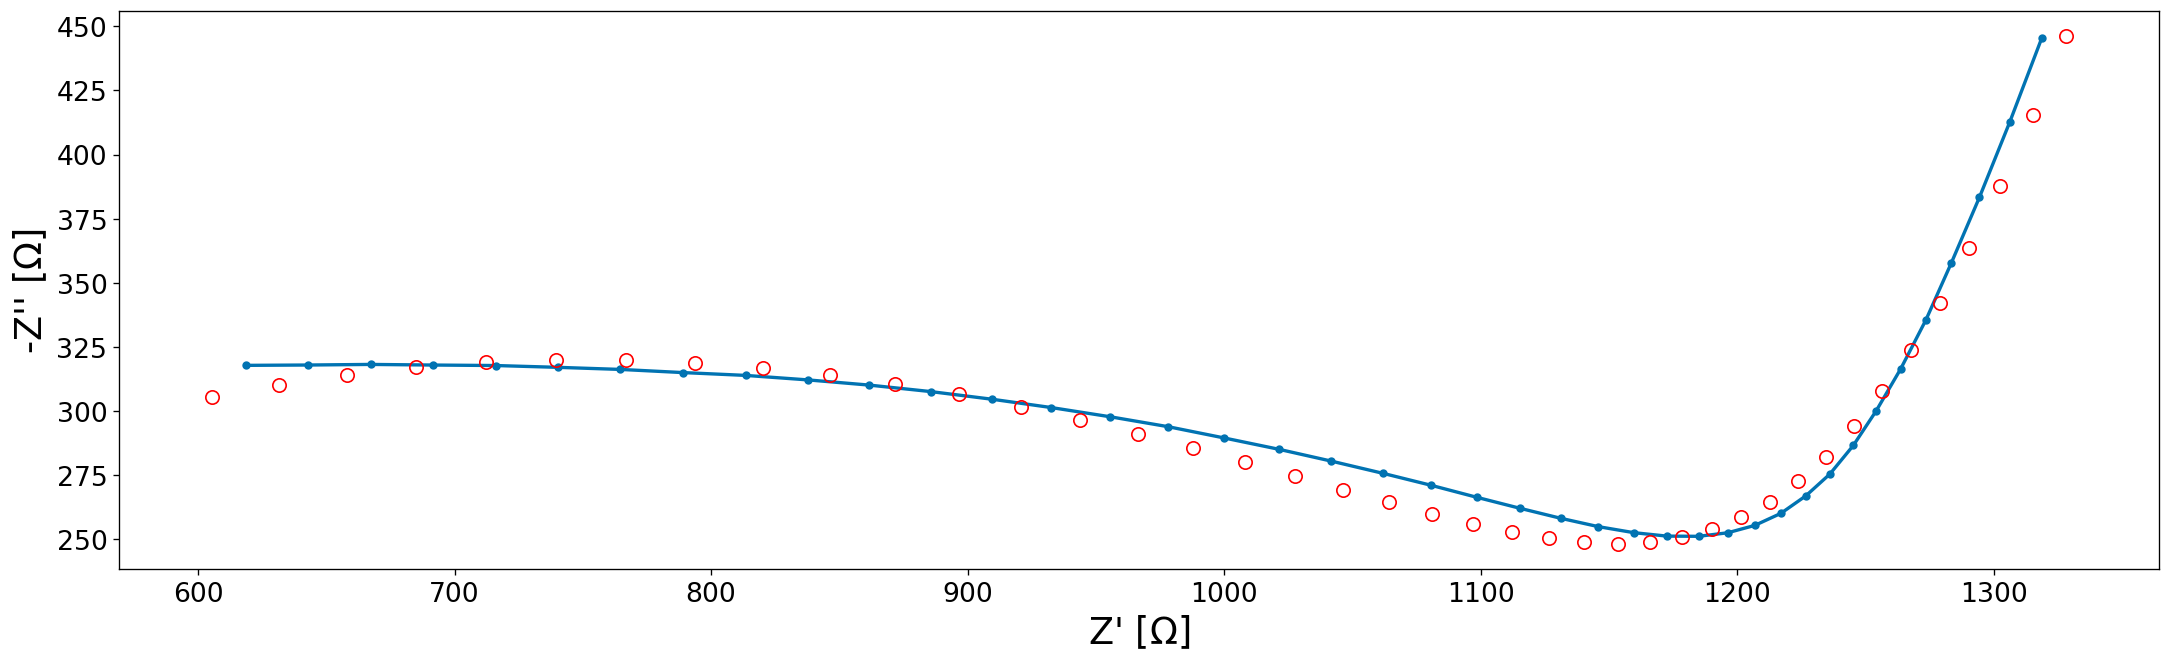

In [79]:
guesser(masked_mpt)

In [40]:
[masked_mpt.fit_Rs[0],masked_mpt.fit_R[0],masked_mpt.fit_n[0],masked_mpt.fit_Q[0],masked_mpt.fit_R2[0],masked_mpt.fit_n2[0],masked_mpt.fit_Q2[0]]

[45.174357806610516,
 31.352103200012337,
 0.9999999999999853,
 5.076372136414454e-09,
 11337.139978957179,
 0.8772780390104212,
 2.3334192826607435e-06]

Note that there are varying amounts of iteration for convergence, you may take longer to achieve threshold

In [41]:
num_RC='auto' 
legend='on'
plot='residuals'
bode='off'
nyq_xlim='none'
nyq_ylim='none'
weight_func='Boukamp'



print('cycle || No. RC-elements ||   u')
ex_mpt.decade = []
ex_mpt.Rparam = []
ex_mpt.t_const = []
ex_mpt.Lin_KK_Fit = []
ex_mpt.R_names = []
ex_mpt.KK_R0 = []
ex_mpt.KK_R = []
ex_mpt.number_RC = []
ex_mpt.number_RC_sort = []

ex_mpt.KK_u = []
ex_mpt.KK_Rgreater = []
ex_mpt.KK_Rminor = []
M = 2
for i in range(len(ex_mpt.df)):
    ex_mpt.decade.append(np.log10(np.max(ex_mpt.df[i].f))-np.log10(np.min(ex_mpt.df[i].f))) #determine the number of RC circuits based on the number of decades measured and num_RC
    ex_mpt.number_RC.append(M)
    ex_mpt.number_RC_sort.append(M) #needed for ex_mpt.KK_R
    ex_mpt.Rparam.append(KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[0]) #Creates intial guesses for R's
    ex_mpt.t_const.append(KK_timeconst(w=ex_mpt.df[i].w, num_RC=int(ex_mpt.number_RC[i]))) #Creates time constants values for ex_mpt.number_RC -(RC)- circuits

    ex_mpt.Lin_KK_Fit.append(minimize(KK_errorfunc, ex_mpt.Rparam[i], method='leastsq', args=(ex_mpt.df[i].w.values, ex_mpt.df[i].re.values, ex_mpt.df[i].im.values, ex_mpt.number_RC[i], weight_func, ex_mpt.t_const[i]) )) #maxfev=99
    ex_mpt.R_names.append(KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[1]) #creates R names
    for j in range(len(ex_mpt.R_names[i])):
        ex_mpt.KK_R0.append(ex_mpt.Lin_KK_Fit[i].params.get(ex_mpt.R_names[i][j]).value)
ex_mpt.number_RC_sort.insert(0,0) #needed for ex_mpt.KK_R
for i in range(len(ex_mpt.df)):
    ex_mpt.KK_R.append(ex_mpt.KK_R0[int(np.cumsum(ex_mpt.number_RC_sort)[i]):int(np.cumsum(ex_mpt.number_RC_sort)[i+1])]) #assigns resistances from each spectra to their respective df
    ex_mpt.KK_Rgreater.append(np.where(np.array(ex_mpt.KK_R)[i] >= 0, np.array(ex_mpt.KK_R)[i], 0) )
    ex_mpt.KK_Rminor.append(np.where(np.array(ex_mpt.KK_R)[i] < 0, np.array(ex_mpt.KK_R)[i], 0) )
    ex_mpt.KK_u.append(1-(np.abs(np.sum(ex_mpt.KK_Rminor[i]))/np.abs(np.sum(ex_mpt.KK_Rgreater[i]))))

for i in range(len(ex_mpt.df)):
    while ex_mpt.KK_u[i] <= 0.75 or ex_mpt.KK_u[i] >= 0.88:
        ex_mpt.number_RC_sort0 = []
        ex_mpt.KK_R_lim = []
        ex_mpt.number_RC[i] = ex_mpt.number_RC[i] + 1
        ex_mpt.number_RC_sort0.append(ex_mpt.number_RC)
        ex_mpt.number_RC_sort = np.insert(ex_mpt.number_RC_sort0, 0,0)
        ex_mpt.Rparam[i] = KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[0] #Creates intial guesses for R's
        ex_mpt.t_const[i] = KK_timeconst(w=ex_mpt.df[i].w, num_RC=int(ex_mpt.number_RC[i])) #Creates time constants values for ex_mpt.number_RC -(RC)- circuits
        ex_mpt.Lin_KK_Fit[i] = minimize(KK_errorfunc, ex_mpt.Rparam[i], method='leastsq', args=(ex_mpt.df[i].w.values, ex_mpt.df[i].re.values, ex_mpt.df[i].im.values, ex_mpt.number_RC[i], weight_func, ex_mpt.t_const[i]) ) #maxfev=99
        ex_mpt.R_names[i] = KK_Rnam_val(re=ex_mpt.df[i].re, re_start=ex_mpt.df[i].re.idxmin(), num_RC=int(ex_mpt.number_RC[i]))[1] #creates R names
        ex_mpt.KK_R0 = np.delete(np.array(ex_mpt.KK_R0), np.s_[0:len(ex_mpt.KK_R0)])
        ex_mpt.KK_R0 = []
        for q in range(len(ex_mpt.df)):
            for j in range(len(ex_mpt.R_names[q])):
                ex_mpt.KK_R0.append(ex_mpt.Lin_KK_Fit[q].params.get(ex_mpt.R_names[q][j]).value)
        ex_mpt.KK_R_lim = np.cumsum(ex_mpt.number_RC_sort) #used for KK_R[i]

        ex_mpt.KK_R[i] = ex_mpt.KK_R0[ex_mpt.KK_R_lim[i]:ex_mpt.KK_R_lim[i+1]] #assigns resistances from each spectra to their respective df
        ex_mpt.KK_Rgreater[i] = np.where(np.array(ex_mpt.KK_R[i]) >= 0, np.array(ex_mpt.KK_R[i]), 0)
        ex_mpt.KK_Rminor[i] = np.where(np.array(ex_mpt.KK_R[i]) < 0, np.array(ex_mpt.KK_R[i]), 0)
        ex_mpt.KK_u[i] = 1-(np.abs(np.sum(ex_mpt.KK_Rminor[i]))/np.abs(np.sum(ex_mpt.KK_Rgreater[i])))
    else:
        print('['+str(i+1)+']'+'            '+str(ex_mpt.number_RC[i]),'           '+str(np.round(ex_mpt.KK_u[i],2)))

ex_mpt.KK_circuit_fit = []
ex_mpt.KK_rr_re = []
ex_mpt.KK_rr_im = []
functs = []
for i in range(2,81):
    functs.append('KK_RC'+str(i))

for i in range(len(ex_mpt.df)):
    cir_num = int(ex_mpt.number_RC[i])
    cir_funct = eval(functs[cir_num - 2])
    ex_mpt.KK_circuit_fit.append(cir_funct(w=ex_mpt.df[0].w, Rs=ex_mpt.Lin_KK_Fit[0].params.get('Rs').value, R_values=ex_mpt.KK_R[0], t_values=ex_mpt.t_const[0]))
    if cir_num >= 81:
        print('RC simulation circuit not defined')
        print('   Number of RC = ', ex_mpt.number_RC)
    ex_mpt.KK_rr_re.append(residual_real(re=ex_mpt.df[i].re, fit_re=ex_mpt.KK_circuit_fit[i].real, fit_im=-ex_mpt.KK_circuit_fit[i].imag)) #relative residuals for the real part
    ex_mpt.KK_rr_im.append(residual_imag(im=ex_mpt.df[i].im, fit_re=ex_mpt.KK_circuit_fit[i].real, fit_im=-ex_mpt.KK_circuit_fit[i].imag)) #relative residuals for the imag part

    self.kk_df = pd.DataFrame({'f':np.log10(self.df_raw.f), 're':self.KK_rr_re[0]*100, 'im':self.KK_rr_im[0]*100})
    self.kk_df['difference'] = abs(self.kk_df['re'] - self.kk_df['im'])
    diff_mean = self.kk_df['difference'].mean()
    masked_df = self.kk_df[self.kk_df['difference'] < diff_mean * number]
    print('MASK BOUNDARIES: ', 10**masked_df['f'].max(),10**masked_df['f'].min())
    masked_mpt = mpt_data(self.path, self.data, mask = [10**masked_df['f'].max(),10**masked_df['f'].min()])

    Rs_guess = 40

    R_guess = 2959
    n_guess = 0.8
    fs_guess = 23023

    R2_guess = 258738
    n2_guess = 0.8
    fs2_guess = 0.2

    fit_guess = masked_mpt.guesser(Rs_guess,R_guess,n_guess,fs_guess,R2_guess,n2_guess,fs2_guess)
    if masked_mpt.counter >= 950 or abs(masked_mpt.error_total) > 1e-10:
        return masked_mpt.masker(number * .9)
    return (10**masked_df['f'].max(),10**masked_df['f'].min())

In [42]:
masker(ex_mpt, .5)

cycle || No. RC-elements ||   u
[1]            9            0.78
MASK BOUNDARIES:  1000018.6000000008 1995.6388999999992


C:\Users\cjang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
C:\Users\cjang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:84: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.imag(ser.to_numpy())` or `ser.to_numpy().imag`.
C:\Users\cjang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: `real` is deprecated and will be removed in a future version. To eliminate this warning for a Series `ser`, use `np.real(ser.to_numpy())` or `ser.to_numpy().real`.
C:\Users\cjang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:85: FutureWarning: `imag` is deprecated and will be removed in a future version. To eliminate t

NameError: name 'params' is not defined